# Model Analysis
<p>In this notebook, we will analyze the performance of the models we have built. We will use the metrics `root_mean_squared_error`, `mean_absolute_error`, and `r2_score` to evaluate the performance of our models. We will also use the `bootstrap` and `kfold` functions to check for overfitting and evaluate how well our models perform on unseen data.</p>

<p>For start, we will perform kfold cross-validation on the baseline models, which constitute of the 'ElasticNet', 'Bayesian Ridge' and 'Support Vector Regressor'. These will set the lower bound of our performance metrics.</p>

- <p>Root Mean Squared Error (RMSE) is a measure that quantifies the error between the predicted and actual values. It is calculated by taking the square root of the mean of the squared differences between the predicted and actual values. The lower the RMSE, the better the model's performance. Moreover, RMSE is sensitive to outliers, which can skew the results.</p>

- <p>Mean Absolute Error (MAE) is a measure that also quantifies the error between the predicted and actual values. It is calculated by taking the mean of the absolute differences between the predicted and actual values. The lower the MAE, the better the model's performance. MAE is less sensitive to outliers than RMSE. Ideally, we aim to optimize both RMSE and MAE to achieve the best model performance.</p>

**<p>We will use the negative RMSE and MAE (due to scikit-learn's scoring table) so we will be maximizing instead of minimizing in some steps (like in feature selection and fine-tuning). However, the plots will still show the positive RMSE and MAE</p>**


- <p>R2 score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It quantifies the goodness of fit, indicating how well the model explains the variance in the target variable. The maximization of this score is desirable. When this score is negative, it indicates that the model's fit is worse than a random guess.</p>

### **Note: Only brief descriptions of the results and the thought process are provided here. For a more in-depth analysis, please refer to the report.**

In [1]:
# Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib
import sys
import os
import optuna
# I had an issue with importing functions from the src directory, so I used chatGPT to get the line below
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import functions

<p>Before defining the models we will load the csv files for development and evaluation. Except for the rows that were removed during cleaning, we will also remove the Host age row and the Sex row as the requirements tell us to construct models that predict BMI from gut microbiome data. Of course, after the analysis is done only on microbes, we will also examine the predictive power of our methods using also sex and age as features.</p>

In [2]:
# Get the working directory
input_path = Path.cwd()
root = input_path.parent
data_path = root / "data" / "development_final_data.csv"
train_df = pd.read_csv(data_path, header=0)
# Go to the dev set and drop the target column as well as the columns that are not microbiome related
x = train_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
# Define y as the target variable
y = train_df['BMI']
# Do the same for the evaluation set
val_df = pd.read_csv(root / "data" / "evaluation_final_data.csv", header=0)
val_x = val_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
val_y = val_df['BMI']

<hr>

### KFold-Cross Validation for baseline models with no feature selection
<p>Below we use kfold cross-validation to evaluate the performance of the baseline models. We will use the `mean_absolute_error`, `root_mean_squared_error`, and `r2_score` functions from `sklearn.metrics` to evaluate the performance of our models. The procedure is run 200 times with 5 folds each time and the results are used to create boxplots for each metric</p>

Model: ElasticNet


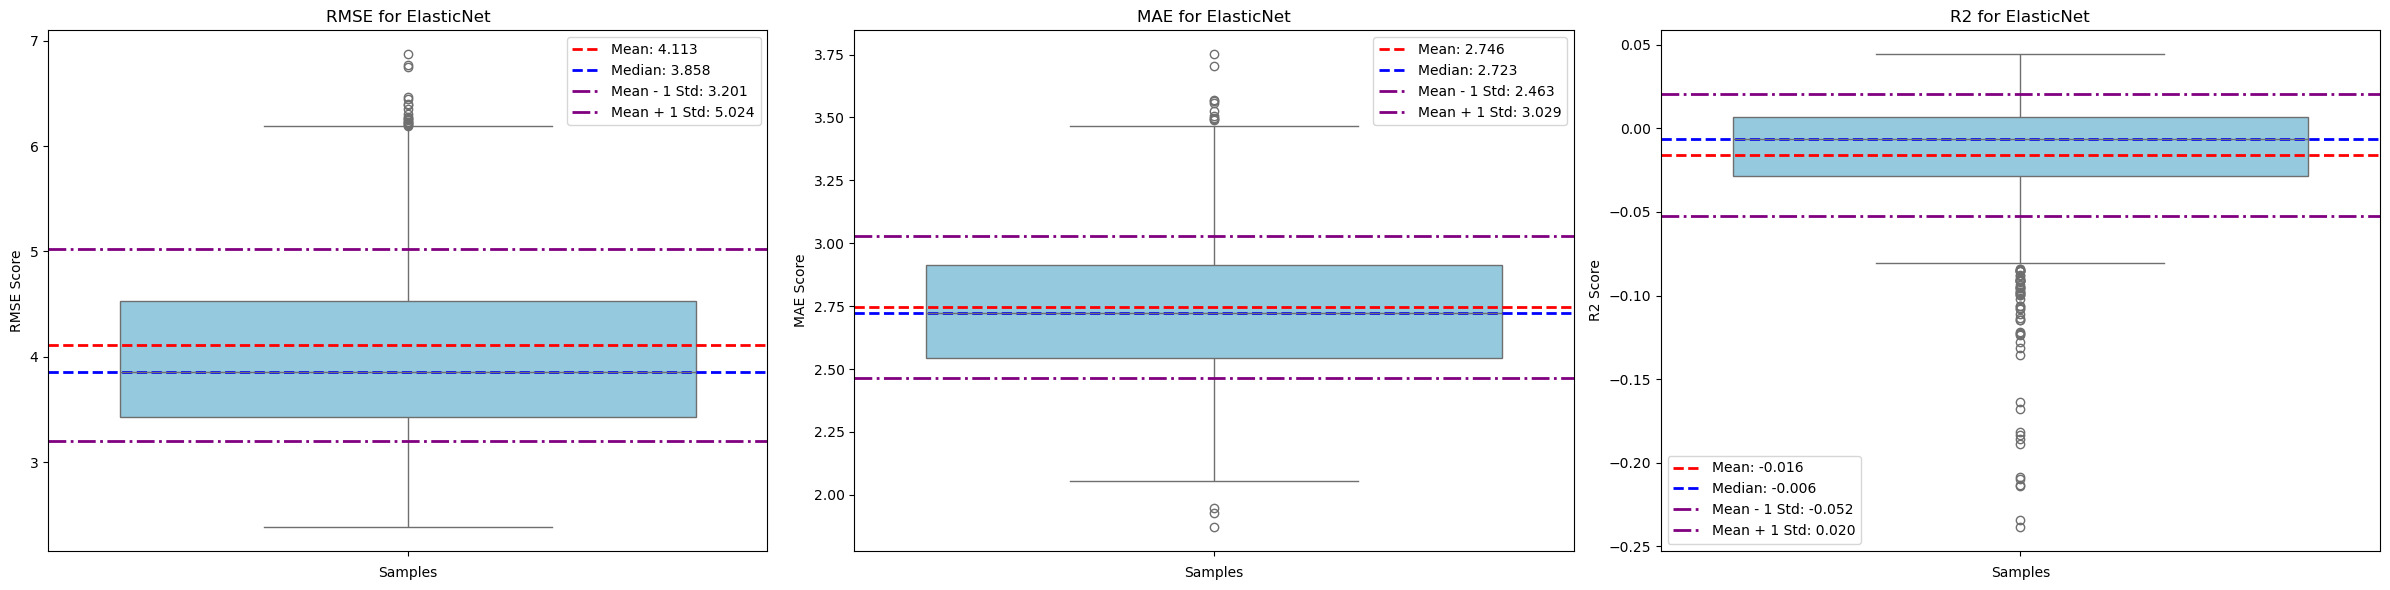

Model: BayesianRidge


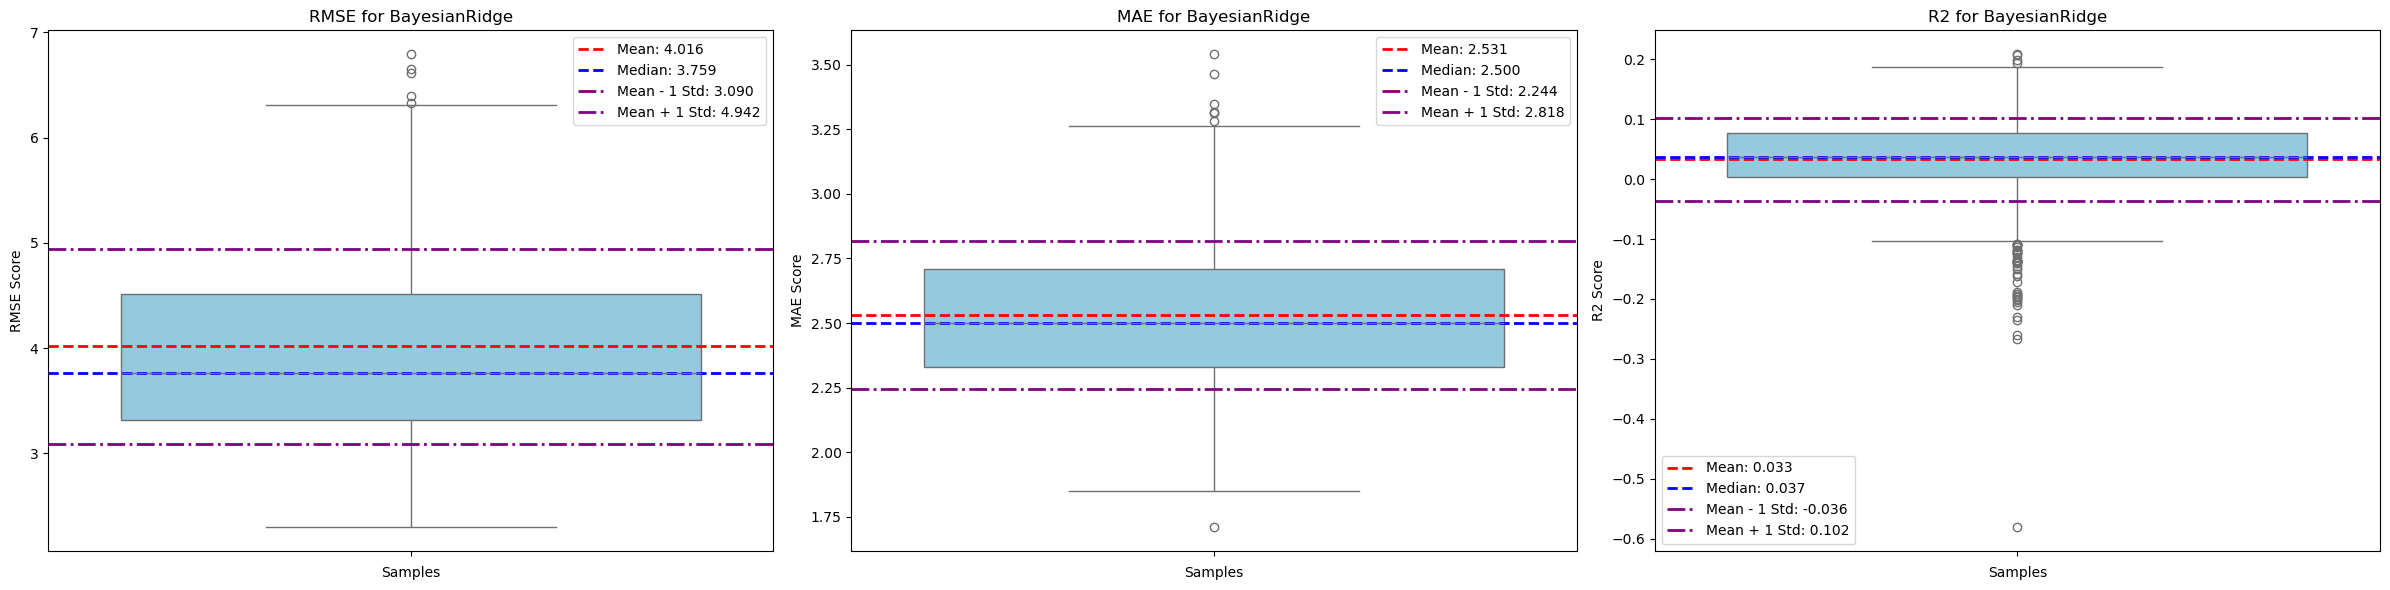

Model: SVR


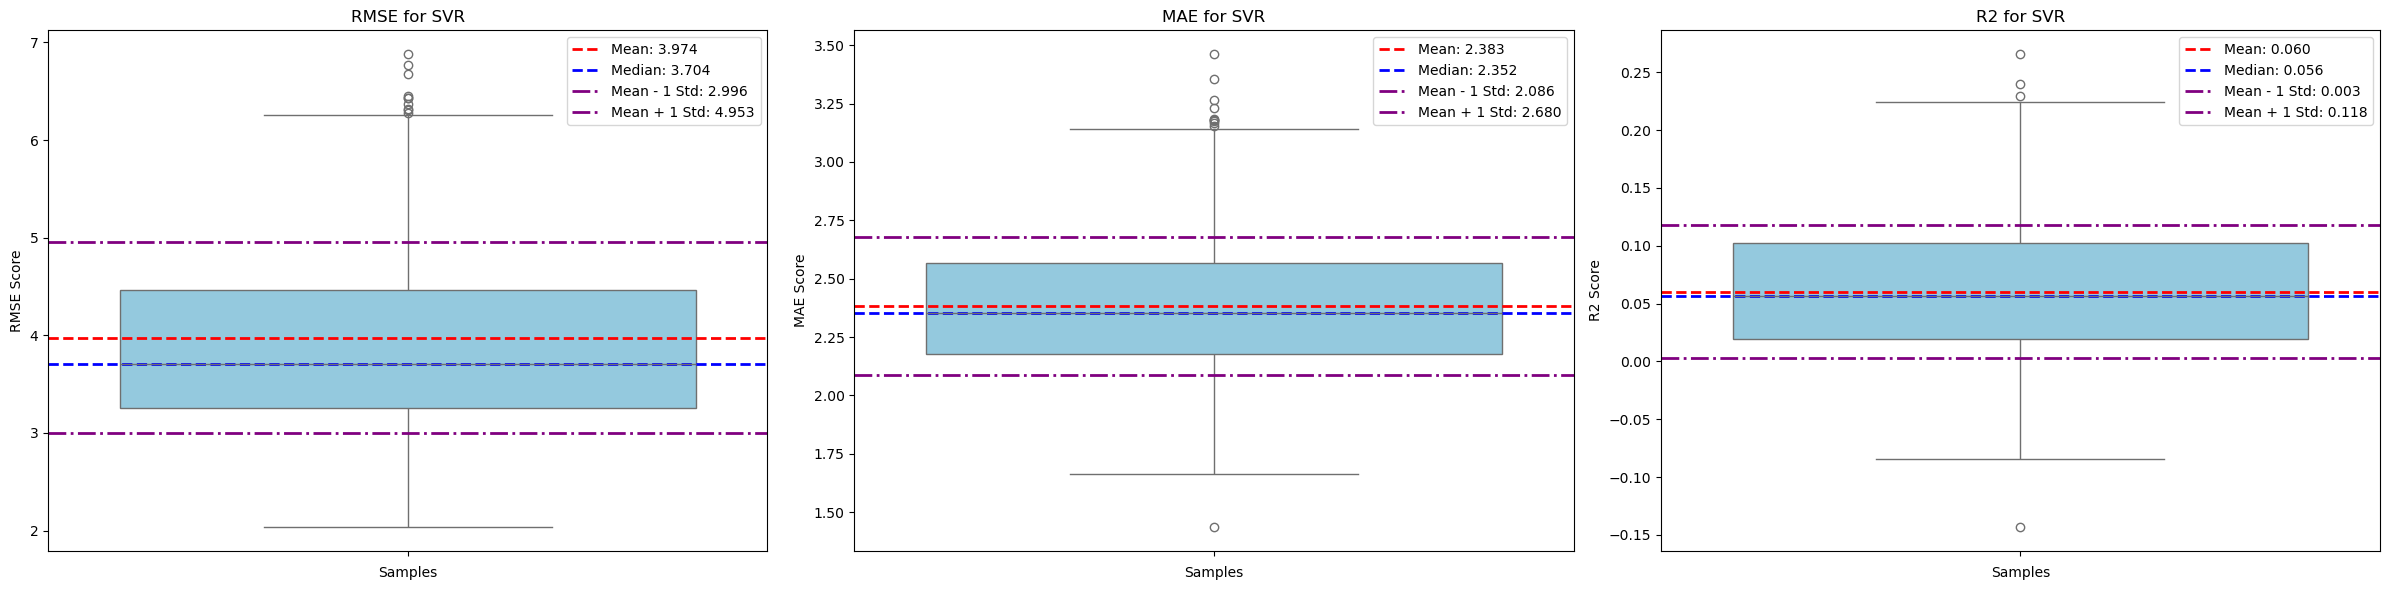

In [3]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    # Train the model on the development set and save it
    functions.bootstrap2boxplot(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"baseline_{model.__class__.__name__}.pkl", save=True, default_path=True)

<hr>

<p>Based on the results from k-fold cross-validation, we can see that the model that seems most promising is the SVR, since it has the lowest mean absolute error (MAE), the lowest root mean squared error (RMSE) and the highest R2 score. Regarding R2, the overall distributions also show the same picture as most of the values for the SVR are found in a range higher than the other models, while it is interesting that the R2 for the ElasticNet is mostly negative, which shows that it is likely to be the least reliable, as a negative R2 score indicates predictions worse than predicting the constantly the mean. This is likely happening due to overfitting, as the other models  have positive values, although small. It is also worth noting that even though the mean and median values are higher for SVR, the std is higher than the other models.</p>

<hr>

## Evaluation - Baseline Models

<p>In order to get multiple metrics for evaluation from a single evaluation set, we use bootstrapping on the evaluation set after training once on the development set. This way, we simulate the process where the model is made to predict on multiple sets of unseen data. Ideally the metrics should be similar to the metrics we get from the kfold cross validation on the development set. It is worth mentioning that the number of samples used per iteration are half of the evaluation dataset size with `replacement=True` which means that the same sample can be picked more than once. </p>

Model: ElasticNet


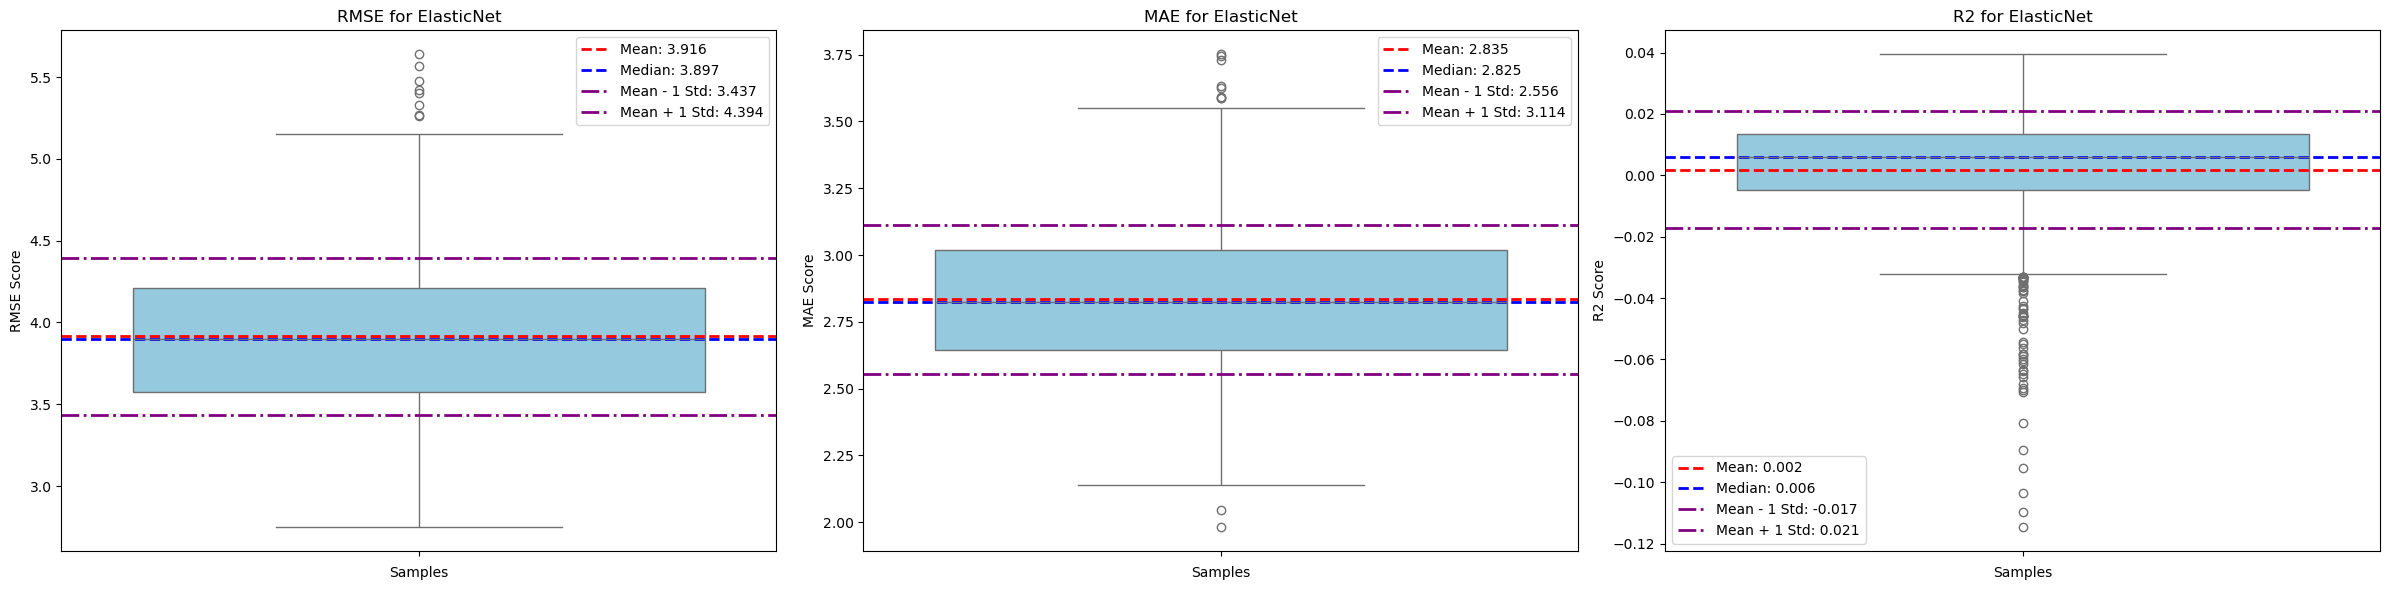

Model: BayesianRidge


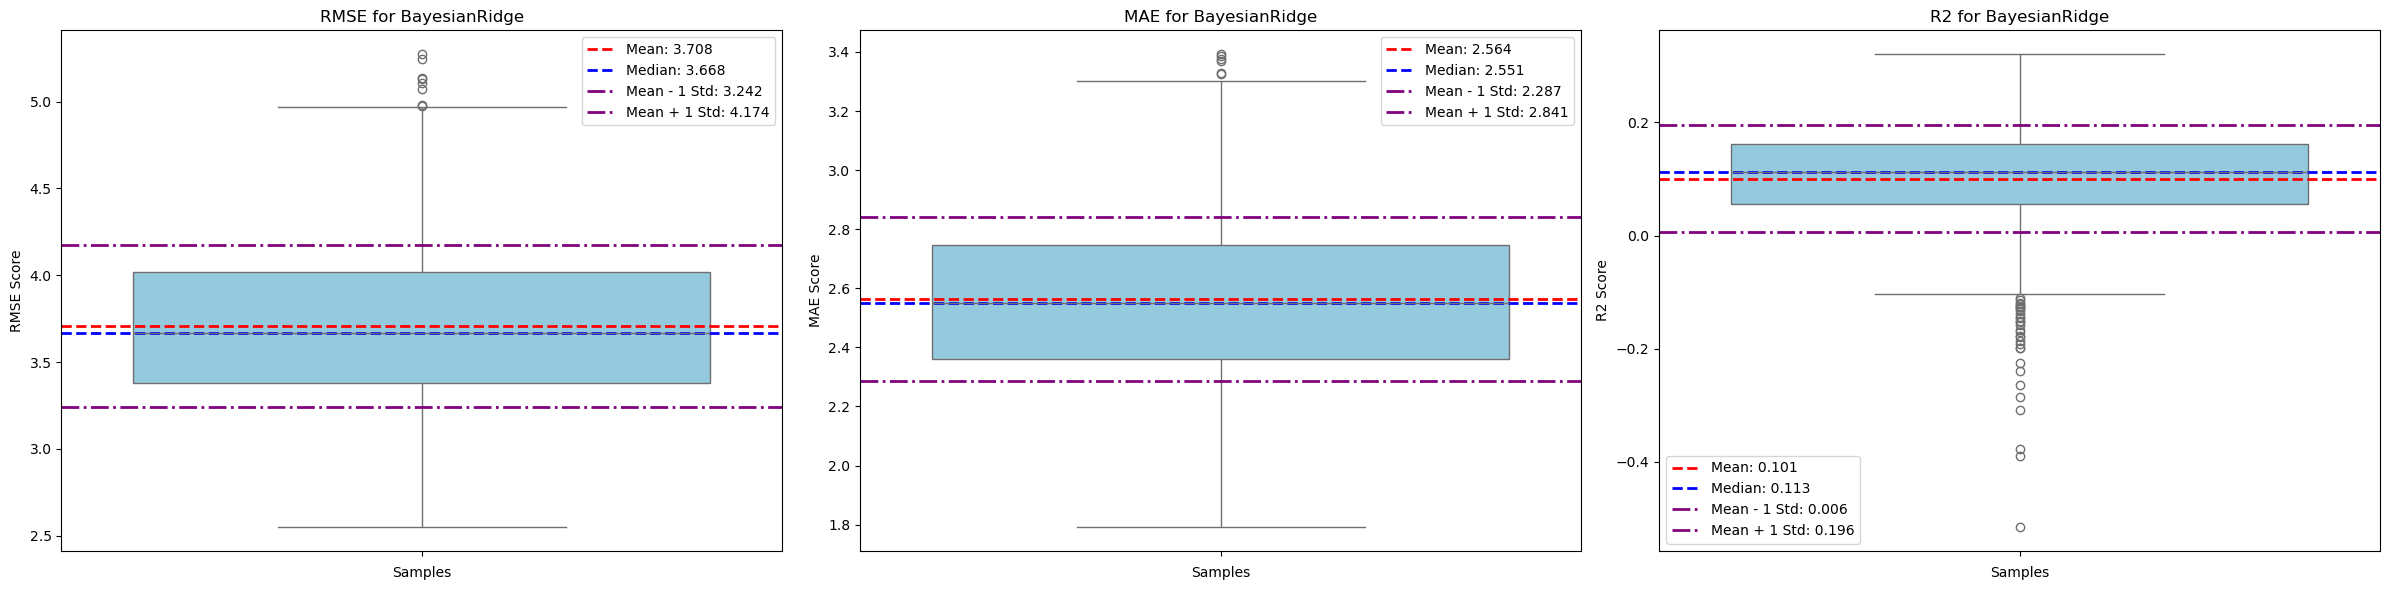

Model: SVR


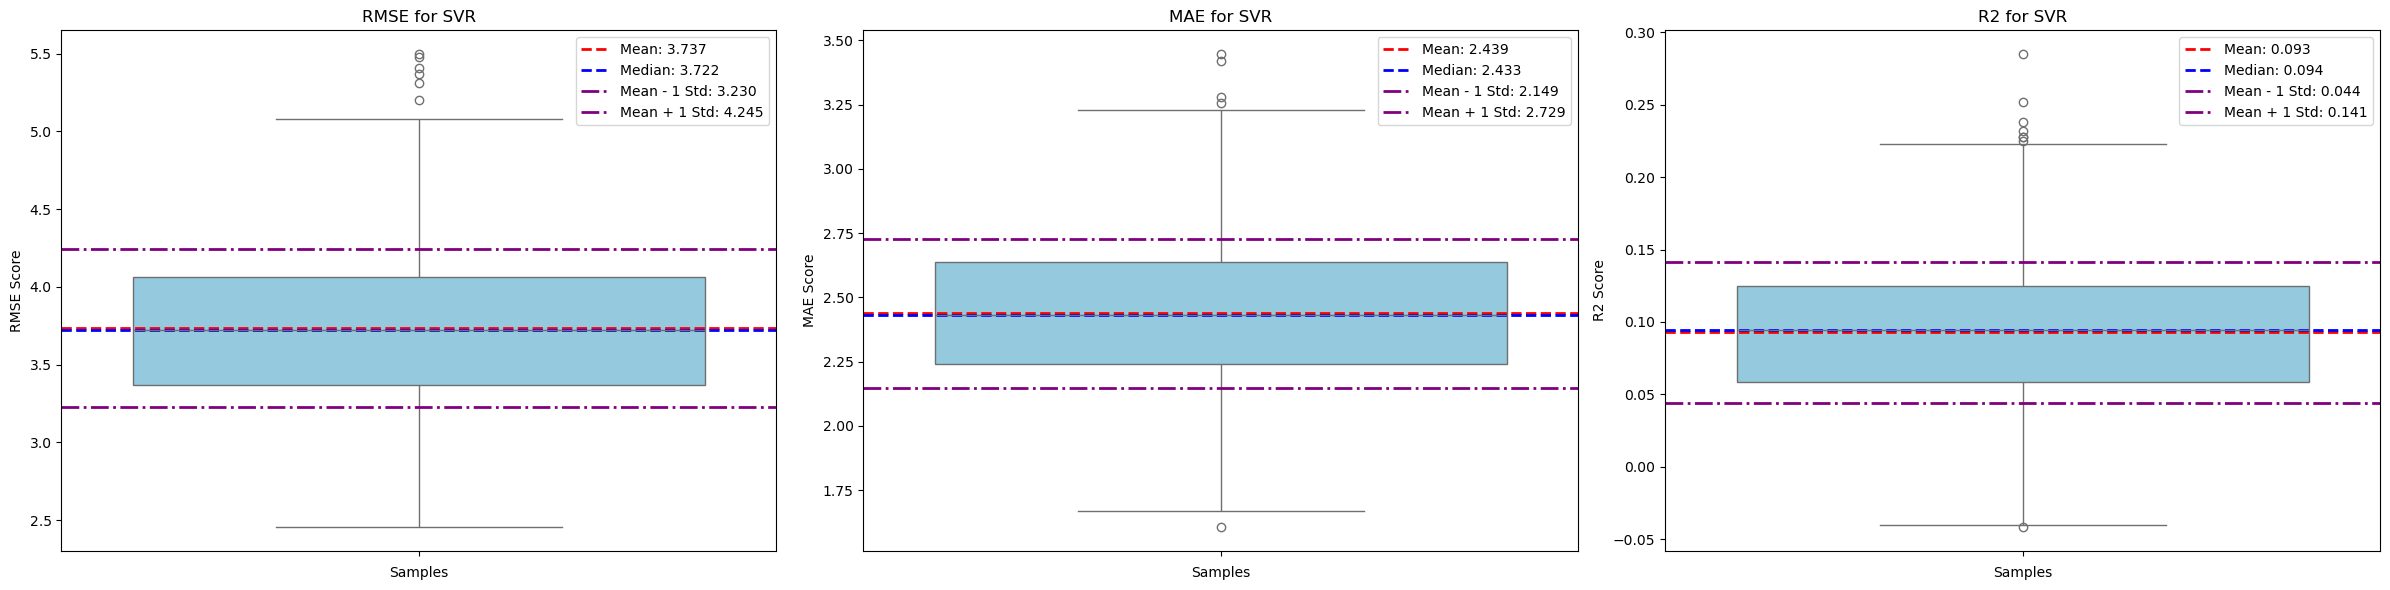

In [4]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    functions.bootstrap2boxplot(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False, save=False)


<p>The plots obtained and their quality seems to be similar to the kfold results. More specifically, the scores seem to be better than the ones from kfold, which is likely due to the fact that here the training set remains the same and only the evaluation set is changing (due to bootstrapping). Finally, the R2 score here is mostly positive for all models although it is still of miniscule value. In conclusion, the evaluation shows that the most promising model is the SVR followed by the bayesian ridge, with the Elastic Net being the worse performing one of the three.</p>
<hr>

## Feature Selection
<p>In this section, we will use optuna for each baseline model in order to assess the best feature selection method among `PCA`, `KernelPCA`, `RFE`, `SelectKBest(mutual_information/r_regression)` and `Sequential Feature Selection` (SFS) based on the maximization of the negative`Root Mean Squared Error`. RFE(CV) and SFS were used separately so the results were compared with the best Optuna result. It should be noted that Grid search was initially used instead of optuna, but lead to suboptimal results for almost every model.</p>

- <p>PCA is an unsupervised technique for dimensionality reduction in machine learning. By leveraging the eigenvectors and eigenvalues of the covariance matrix, PCA can reduce the dimensionality of the data while preserving the most important features. It is a linear transformation technique that can be applied to both numerical and categorical data. The number of components to retain is specified by the `n_components` parameter, which also allows to choose a float in order for PCA to return the number of components that explain at least a certain percentage of the variance in the data. Here we first checked how many features are required to explain 95% of the variance in the dataset and set that number as the maximum numver of features to be selected by PCA.</p>

- <p>Kernel PCA is a variant of PCA which can transform data non-linearly based on a predefined kernel (a radial basis function kernel is the default, which is basically a gaussian kernel). Although really powerful due to the fact that it can handle non-linearities, it can also distort the structure of the data so it is usually necessary to calculate the reconstruction error. Here, this will not be performed as kernel PCA is not used for the final model.</p>

- <p>RFE is a feature selection technique that can be used for both classification and regression problems. It works by recursively selecting the best features based on a cross-validation score. Apart from being computationally expensive, it also requires specific parameters to be provided by the estimator regarding the importance of features, which makes it impossible to use for SVR with the default RBF kernel.</p>

- <p>SFS is a brute force and exhaustive in nature feature selection technique, that tries to fit an estimator to all the possible combinations of features of a specific number. Due to this recursive nature it is computationally intensive and likely to overfit if the dataset is small and/or the number of features selected too small.</p>

<hr>

#### **Grid search and feature selection**
<p>Grid search was used in the beginning to test some options for feature selection and get a feel for how many components would be needed for each model as well as if KernelPCA would perform better than PCA. Due to its exhaustive nature, optuna was deemed a better option.</p>

In [5]:
models = [ElasticNet(), BayesianRidge(), SVR()]
cv = RepeatedKFold(n_splits=5, n_repeats=10)
for model in models:
    print(model.__class__.__name__)
    grid = functions.grid_search(model, x, y, cv=cv, scoring='neg_root_mean_squared_error')
    print("Best parameters:", grid.best_params_)
    print("Best score:", grid.best_score_)

ElasticNet
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 10}
Best score: -4.0770482040929314
BayesianRidge
Best parameters: {'feature_selector': KernelPCA(kernel='rbf'), 'feature_selector__n_components': 95}
Best score: -4.020610074634586
SVR
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 30}
Best score: -3.9827121398804213


<hr>

#### **RFE-CV**

<p>RFE-CV was used for feature selection for Elastic Net and Bayesian Ridge. Afterwards, plots were made, with confidence intervals <b>according to the documentation in sklearn</b> to show the information gain as features increase for each algorithm.</p>

ElasticNet
Optimal number of features: 7
Selected features: ['Alistipes putredinis', 'Desulfonispora thiosulfatigenes', 'Ruminococcus champanellensis', 'Sporobacter termitidis', 'Clostridium clariflavum', 'Clostridium symbiosum', 'Eubacterium sulci']
Mean negative RMSE for optimal features (7): -4.1667


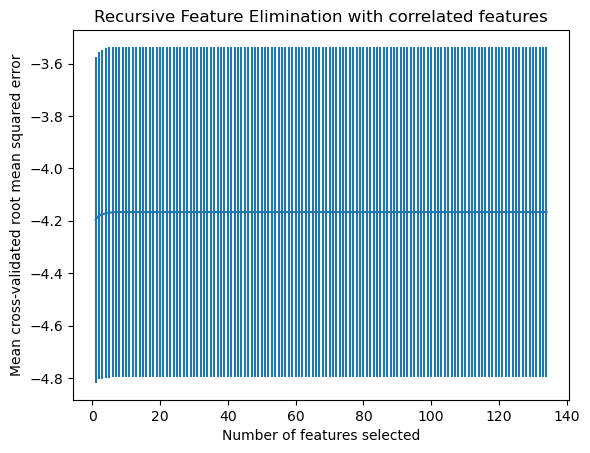

BayesianRidge
Optimal number of features: 134
Selected features: ['Acholeplasma axanthum', 'Acidaminococcus fermentans', 'Acidaminococcus intestini', 'Actinomyces lingnae', 'Akkermansia muciniphila', 'Alistipes finegoldii', 'Alistipes indistinctus', 'Alistipes obesi', 'Alistipes onderdonkii', 'Alistipes putredinis', 'Alistipes shahii', 'Alistipes sp. RMA 9912', 'Alistipes timonensis', 'Anaerofilum pentosovorans', 'Anaerofustis stercorihominis', 'Anaerostipes butyraticus', 'Anaerostipes caccae', 'Anaerotruncus colihominis', 'Bacillus megaterium', 'Bacillus nealsonii', 'Bacteroides eggerthii', 'Bacteroides fragilis', 'Bacteroides gallinarum', 'Bacteroides graminisolvens', 'Bacteroides intestinalis', 'Bacteroides massiliensis', 'Bacteroides ovatus', 'Bacteroides plebeius', 'Bacteroides salyersiae', 'Barnesiella viscericola', 'Bifidobacterium bifidum', 'Bifidobacterium pseudocatenulatum', 'Bifidobacterium saguini', 'Bifidobacterium tsurumiense', 'Bilophila wadsworthia', 'Blautia coccoides'

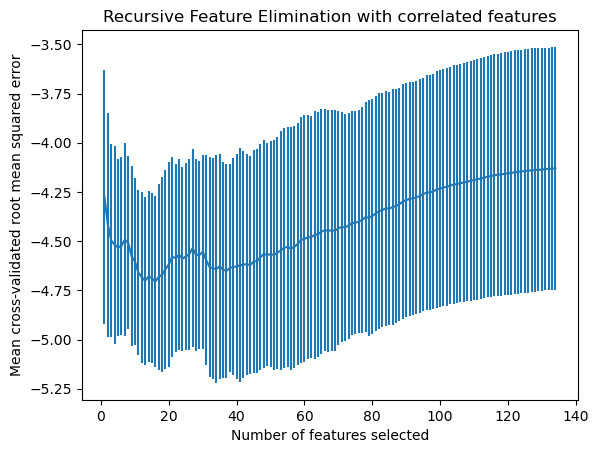

In [5]:
from sklearn.feature_selection import RFECV
models = [ElasticNet(), BayesianRidge()]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
features_per_model = {}
for model in models:
    features_per_model[model.__class__.__name__] = []
    print(model.__class__.__name__)
    rfecv = RFECV(estimator=model, 
                step=1, cv=cv, 
                scoring='neg_root_mean_squared_error',
                min_features_to_select=1
                )
    rfecv.fit(x, y)
    print('Optimal number of features: %d' % rfecv.n_features_)
    # If x is a DataFrame, this will list the selected features by name.
    selected_features = x.columns[rfecv.support_]
    selected_features_list = selected_features.tolist()
    features_per_model[model.__class__.__name__].extend(selected_features_list)
    print("Selected features:", selected_features_list)
    # Number of features tested by RFE:
    n_features_list = np.arange(
        rfecv.min_features_to_select, 
        x.shape[1] + 1,               
        rfecv.step                     
    )
    # Only take as many points as in cv_results_:
    n_features_list = n_features_list[:len(rfecv.cv_results_["mean_test_score"])]
    optimal_index = list(n_features_list).index(rfecv.n_features_)
    optimal_score = rfecv.cv_results_["mean_test_score"][optimal_index]
    print("Mean negative RMSE for optimal features ({}): {:.4f}".format(rfecv.n_features_, optimal_score))
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.errorbar(
        x=n_features_list,
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean cross-validated root mean squared error")
    plt.title("Recursive Feature Elimination with correlated features")
    plt.show()


In [6]:
# Train each model with its corresponding features
x_mod_elnet = x[features_per_model['ElasticNet']]
x_mod_bayesian = x[features_per_model['BayesianRidge']]
x_val_elnet = val_x[features_per_model['ElasticNet']]
x_val_bayesian = val_x[features_per_model['BayesianRidge']]
print(x_mod_elnet.shape)
print(x_mod_bayesian.shape)

(489, 7)
(489, 134)


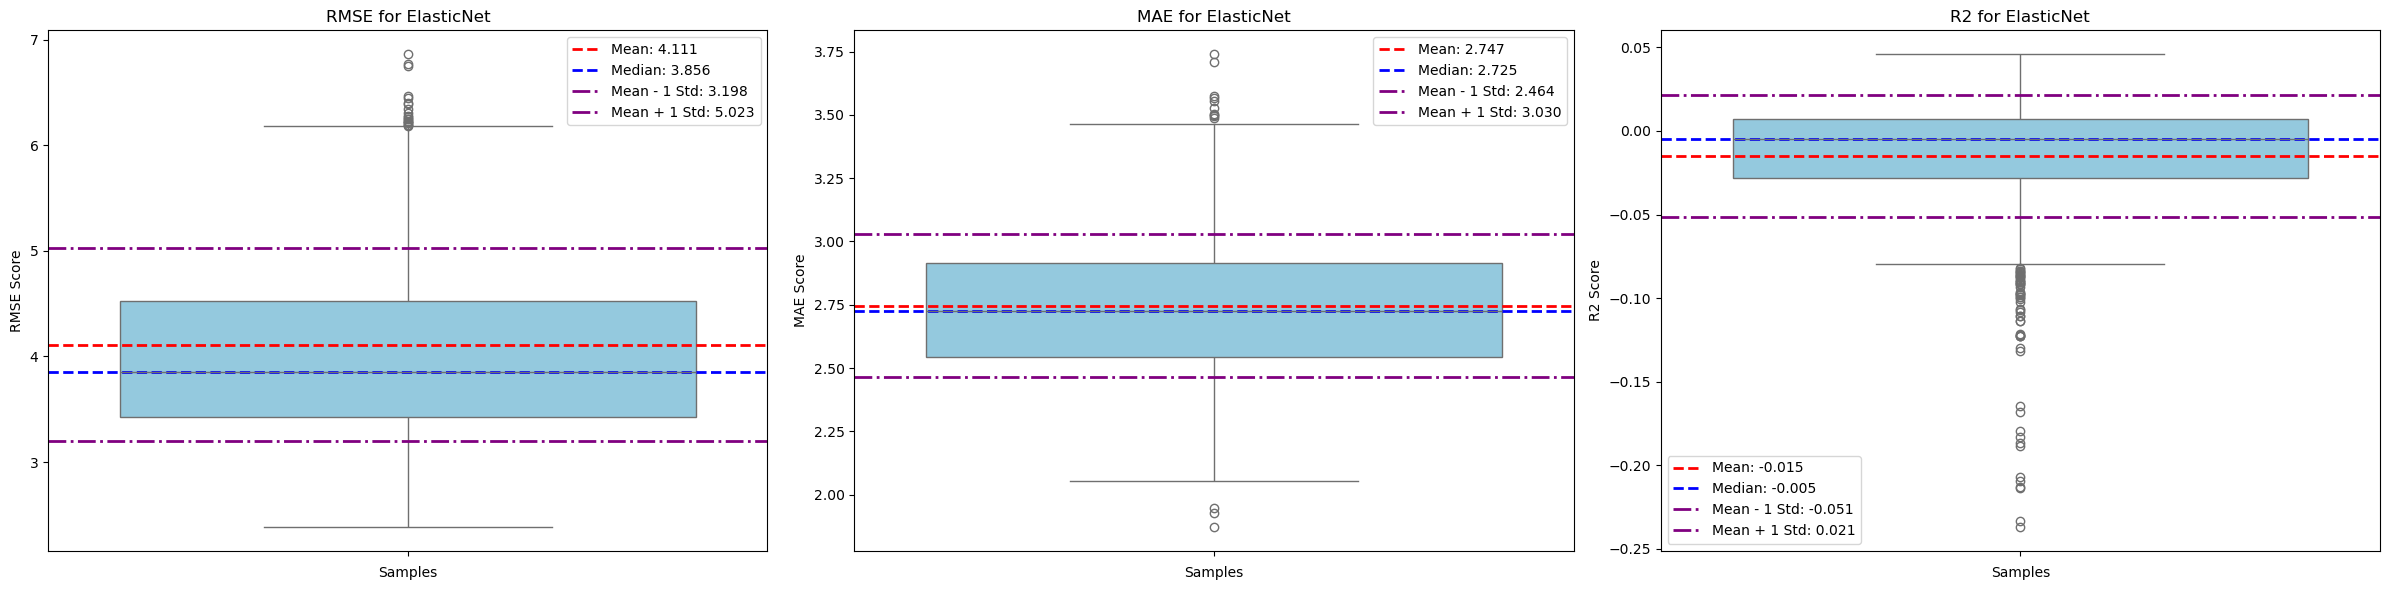

In [7]:
model = ElasticNet()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model)
functions.bootstrap2boxplot(x_mod_elnet, y, x_val_elnet, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"baseline_{model.__class__.__name__}_rfe.pkl", save=True, default_path=True)

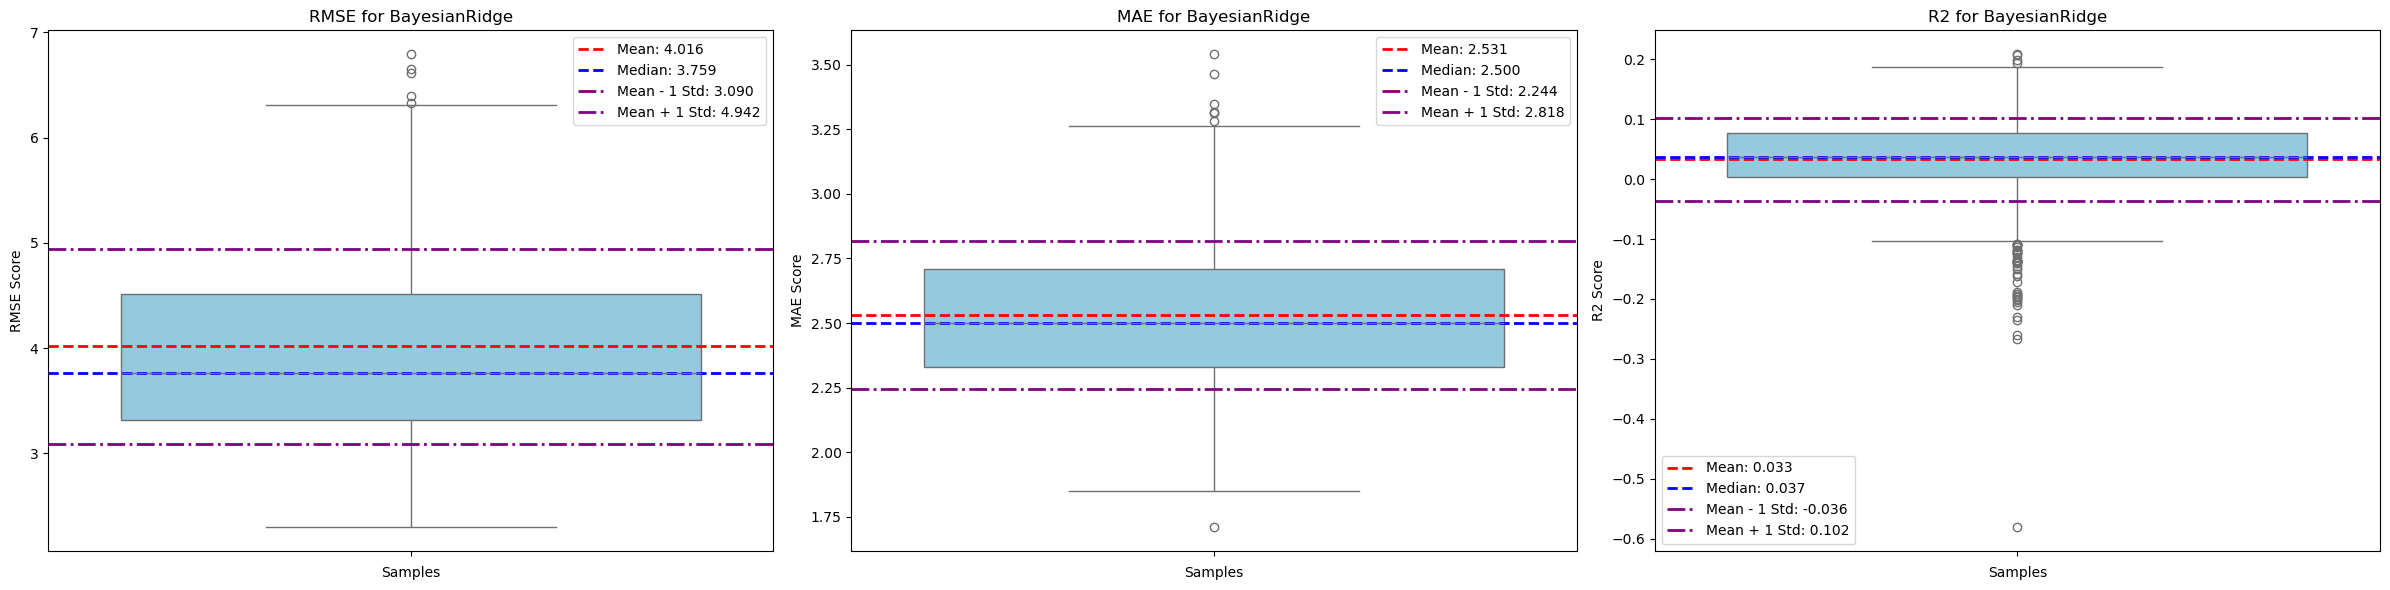

In [8]:
model = BayesianRidge()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model)
functions.bootstrap2boxplot(x_mod_bayesian, y, x_val_bayesian, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"baseline_{model.__class__.__name__}_rfe.pkl", save=True, default_path=True)


<p>Although, the number of features for Elastic Net are dramatically reduced, the RMSE seems to be higher than with the PCA suggested by Grid-search. Additionally, the number of features for Bayesian Ridge are not significantly reduced while at the same time, the confidence intervals (for Elastic Net) are quite wide, showing that there is a lot of uncertainty in the results.</p>

<p>The boxplots created after choosing only the features obtained from RFE-CV show that the results are similar with the baseline models before feature selection, however we also need to figure out a good feature selection method for SVR. Thus, the results of Optuna will also be examined to select the best feature selection method for each model.</p>

<hr>

#### **Optuna and Feature Selection**
</p>Optuna was used to select the best feature selection technique for each model. The results were then plotted using boxplots to visualize the performance of the suggested techniques based on the three scores mentioned</p>

In [9]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: functions.optuna_dim_reduction(trial, model, x, y), n_trials=100)
    print(study.best_params)
    print(study.best_value)

[I 2025-04-10 14:10:57,952] A new study created in memory with name: no-name-90614e5e-77e9-4439-ab57-c2241b435ff6
[I 2025-04-10 14:10:58,702] Trial 0 finished with value: -4.057239235818639 and parameters: {'method': 'PCA', 'n_components': 92}. Best is trial 0 with value: -4.057239235818639.
[I 2025-04-10 14:11:00,179] Trial 1 finished with value: -4.05535681983994 and parameters: {'method': 'KernelPCA', 'kernel': 'linear', 'n_components': 45}. Best is trial 1 with value: -4.05535681983994.
[I 2025-04-10 14:11:01,791] Trial 2 finished with value: -4.117101733388933 and parameters: {'method': 'KernelPCA', 'kernel': 'poly', 'degree': 3, 'n_components': 59}. Best is trial 1 with value: -4.05535681983994.
[I 2025-04-10 14:11:08,416] Trial 3 finished with value: -4.117103162478023 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 8}. Best is trial 1 with value: -4.05535681983994.
[I 2025-04-10 14:11:09,699] Trial 4 finished with value: -4.05565935000372 a

{'method': 'PCA', 'n_components': 47}
-4.054889806277634


[I 2025-04-10 14:13:06,884] Trial 0 finished with value: -4.046243735599154 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 75}. Best is trial 0 with value: -4.046243735599154.
[I 2025-04-10 14:13:08,116] Trial 1 finished with value: -4.029587295034988 and parameters: {'method': 'KernelPCA', 'kernel': 'linear', 'n_components': 31}. Best is trial 1 with value: -4.029587295034988.
[I 2025-04-10 14:13:08,813] Trial 2 finished with value: -4.029341330025938 and parameters: {'method': 'PCA', 'n_components': 34}. Best is trial 2 with value: -4.029341330025938.
[I 2025-04-10 14:13:10,377] Trial 3 finished with value: -4.037333888324593 and parameters: {'method': 'KernelPCA', 'kernel': 'linear', 'n_components': 65}. Best is trial 2 with value: -4.029341330025938.
[I 2025-04-10 14:13:11,180] Trial 4 finished with value: -4.042035749187561 and parameters: {'method': 'PCA', 'n_components': 16}. Best is trial 2 with value: -4.029341330025938.
[I 2025-04-10 14:

{'method': 'PCA', 'n_components': 47}
-4.0207681515417075


[I 2025-04-10 14:15:11,909] Trial 0 finished with value: -4.140220758213591 and parameters: {'method': 'SelectKBest', 'sk_method': 'r_regression', 'k': 6}. Best is trial 0 with value: -4.140220758213591.
[I 2025-04-10 14:15:13,079] Trial 1 finished with value: -4.033733838443078 and parameters: {'method': 'SelectKBest', 'sk_method': 'r_regression', 'k': 91}. Best is trial 1 with value: -4.033733838443078.
[I 2025-04-10 14:15:14,474] Trial 2 finished with value: -3.9808043108303637 and parameters: {'method': 'PCA', 'n_components': 39}. Best is trial 2 with value: -3.9808043108303637.
[I 2025-04-10 14:15:21,528] Trial 3 finished with value: -4.054122009963088 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 39}. Best is trial 2 with value: -3.9808043108303637.
[I 2025-04-10 14:15:24,308] Trial 4 finished with value: -4.057452202781391 and parameters: {'method': 'KernelPCA', 'kernel': 'rbf', 'n_components': 94}. Best is trial 2 with value: -3.980804310

{'method': 'PCA', 'n_components': 94}
-3.974097426880594


According to Optuna: 
- The best feature selection method for ElasticNet is PCA with 47 components. 

- The best feature selection method for BayesianRidge is also PCA with 47 components.

- The best feature selection method for SVR is PCA with 94 components.

(KernelPCA with linear kernel is the same as PCA mathematically)

Model: ElasticNet


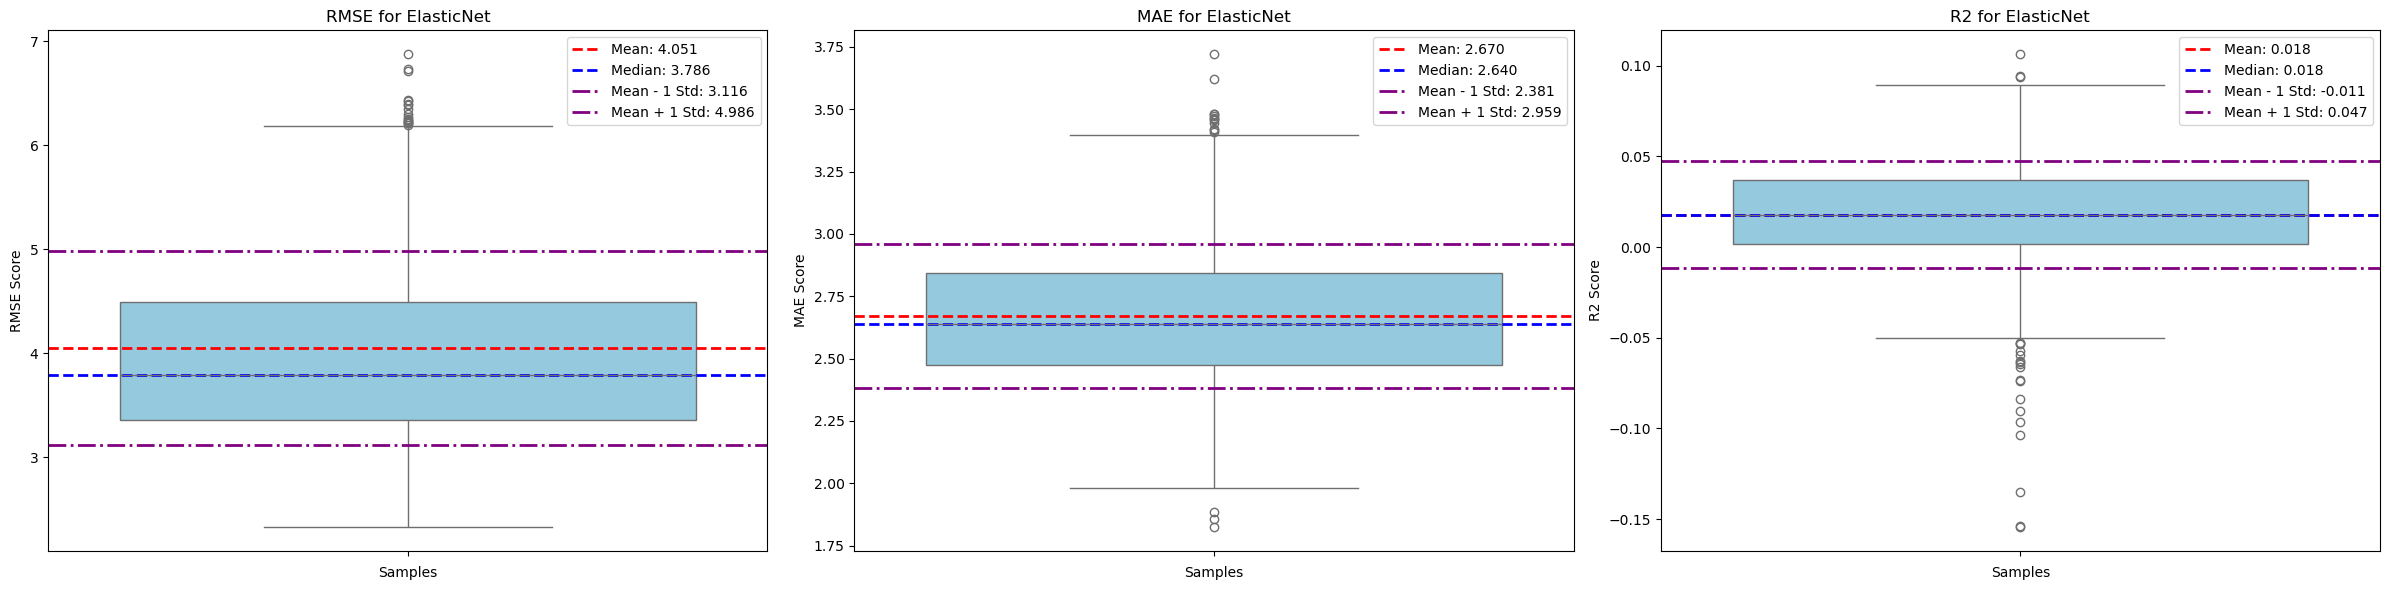

Model: BayesianRidge


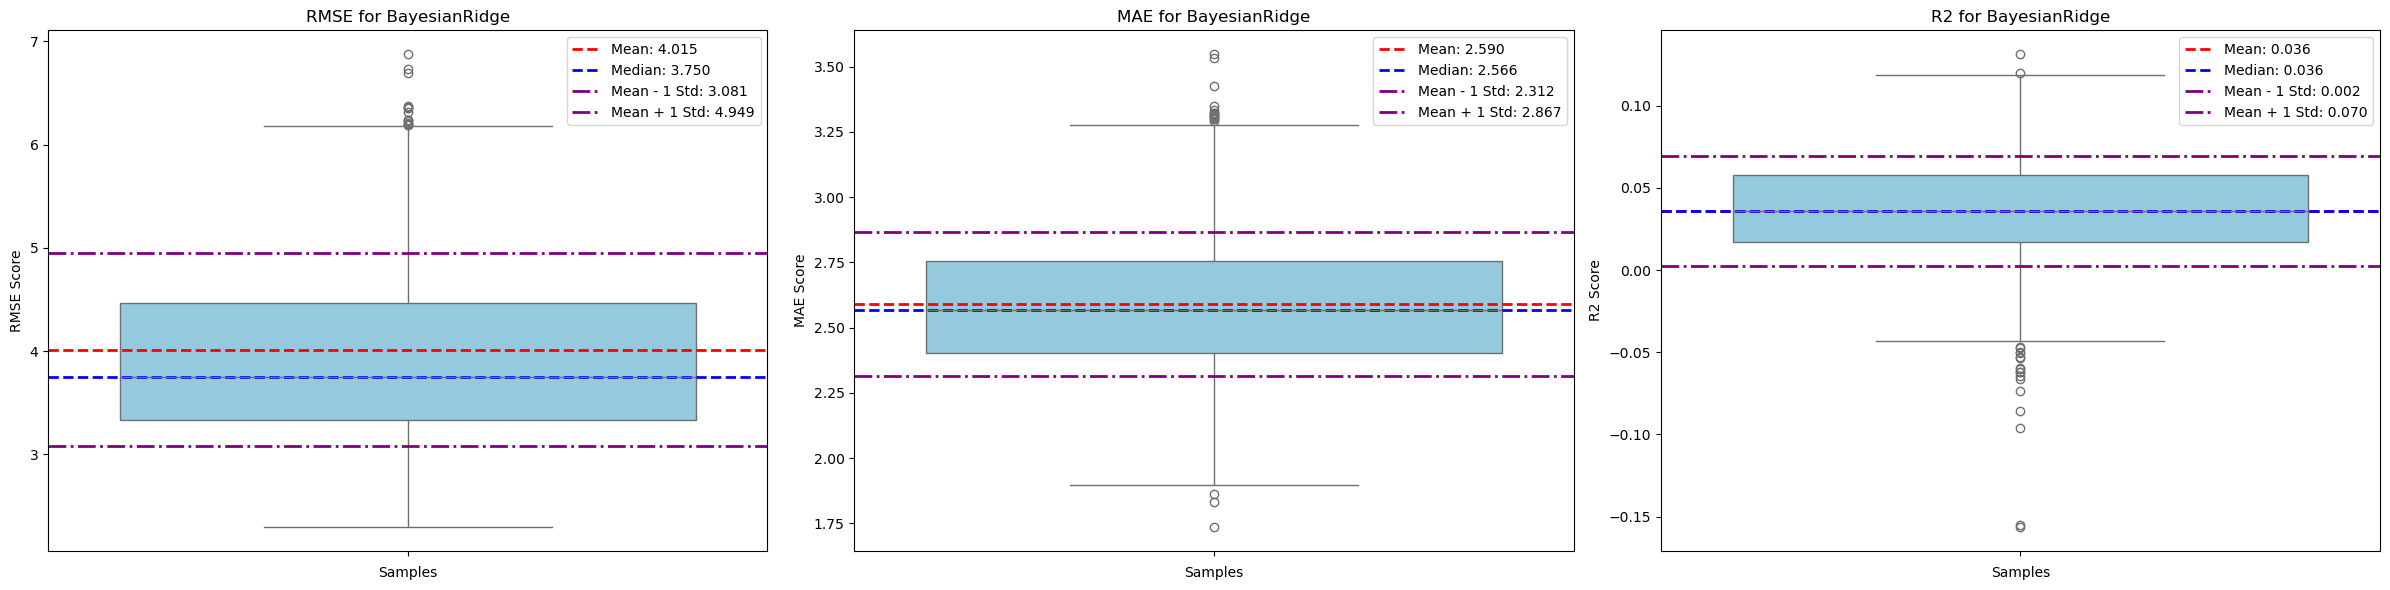

Model: SVR


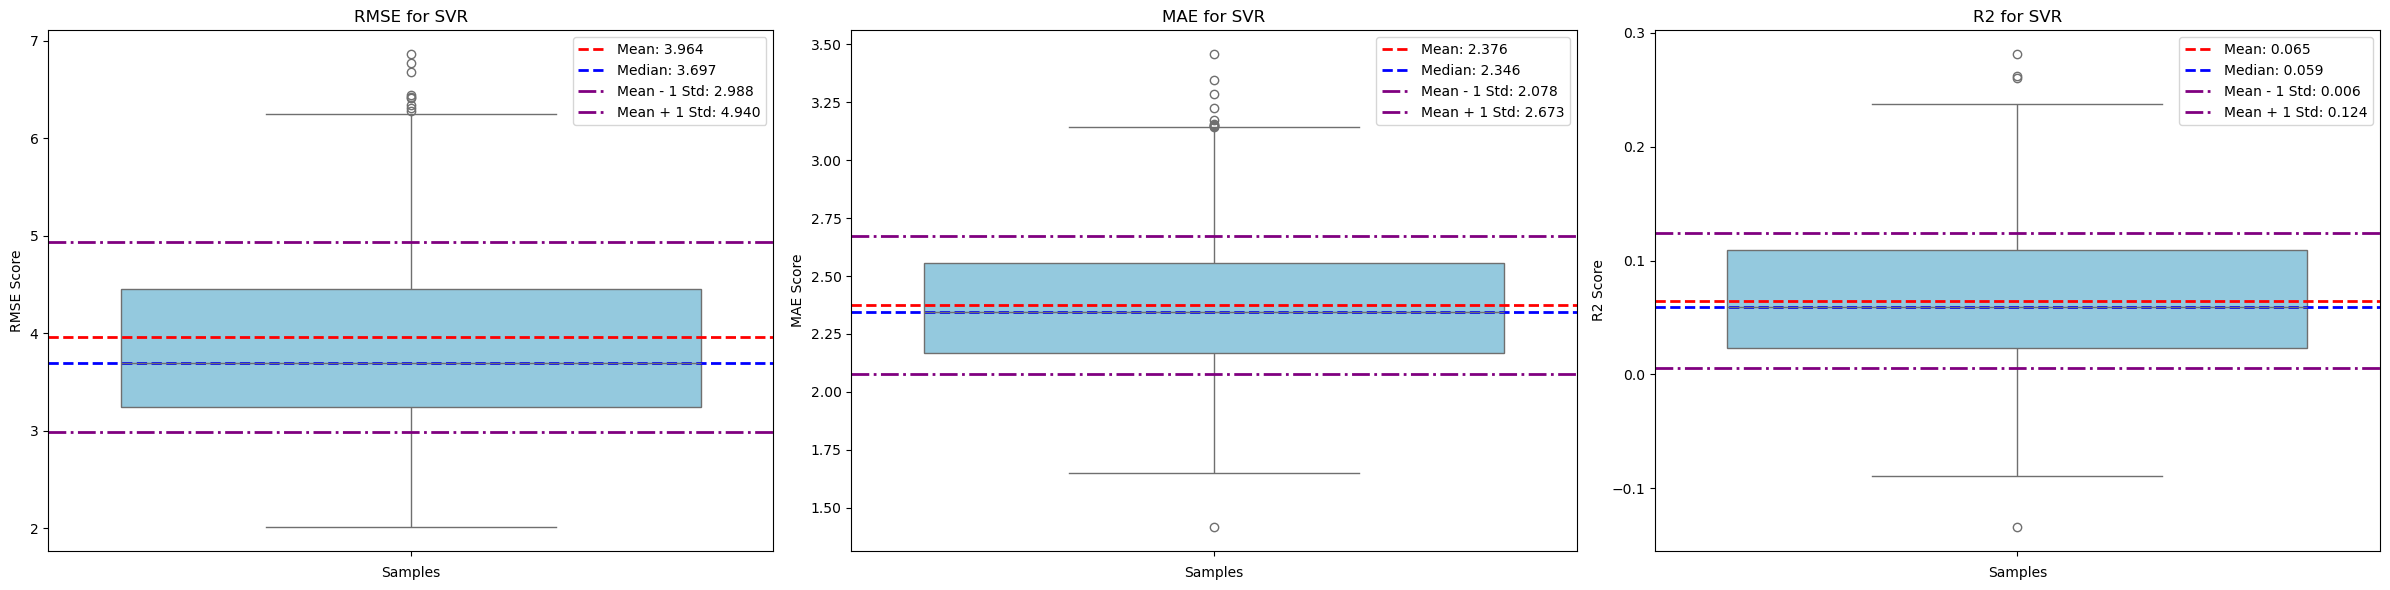

In [10]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))

    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))

    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=94))
    functions.bootstrap2boxplot(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"baseline_{model.__class__.__name__}_pca.pkl", save=True, default_path=True)

<p>All three options achieve a significant reduction in the number of features and a reduction in the RMSE score compared to RFE-CV. Moreover, there is also a slight reduction in RMSE and MAE as well as a slight increase in R2 score, which indicates that the reduction of features helps the models converge to a better solution. Notably, regarding BayesianRidge, the RFECV seems to be performing slightly better than the optuna suggested method of SelectKBest, however due to the tradeoff in the number of features is worth using the Optuna suggested methods instead. Additionally, R2 score seems to have improved after feature selection for all models, while the same holds true for the evaluation plots.</p>

Model: ElasticNet


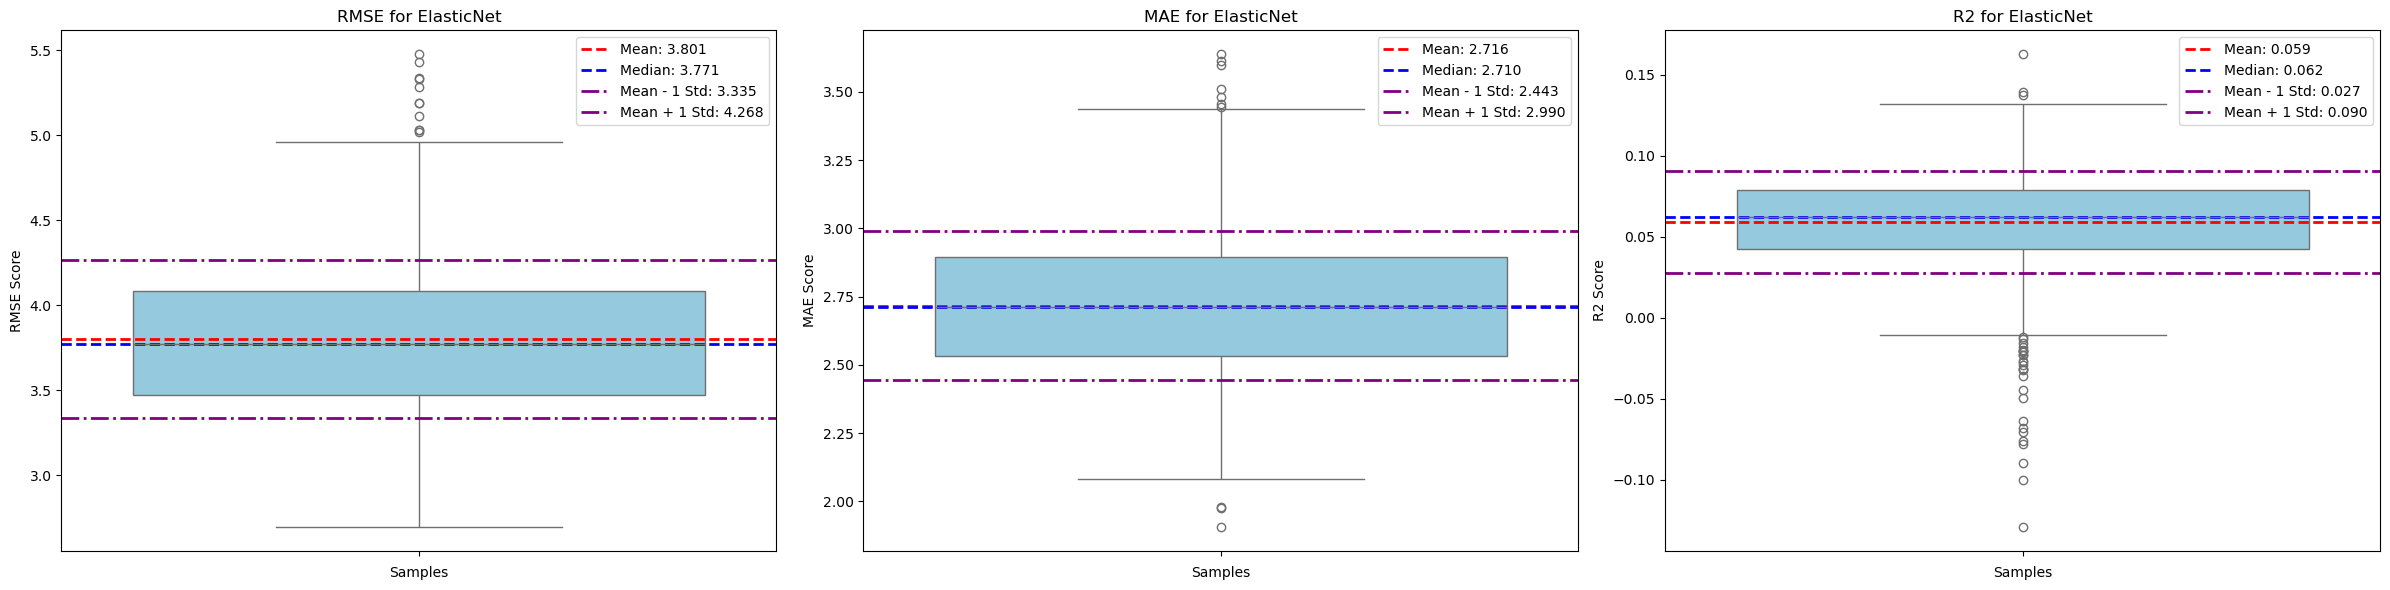

Model: BayesianRidge


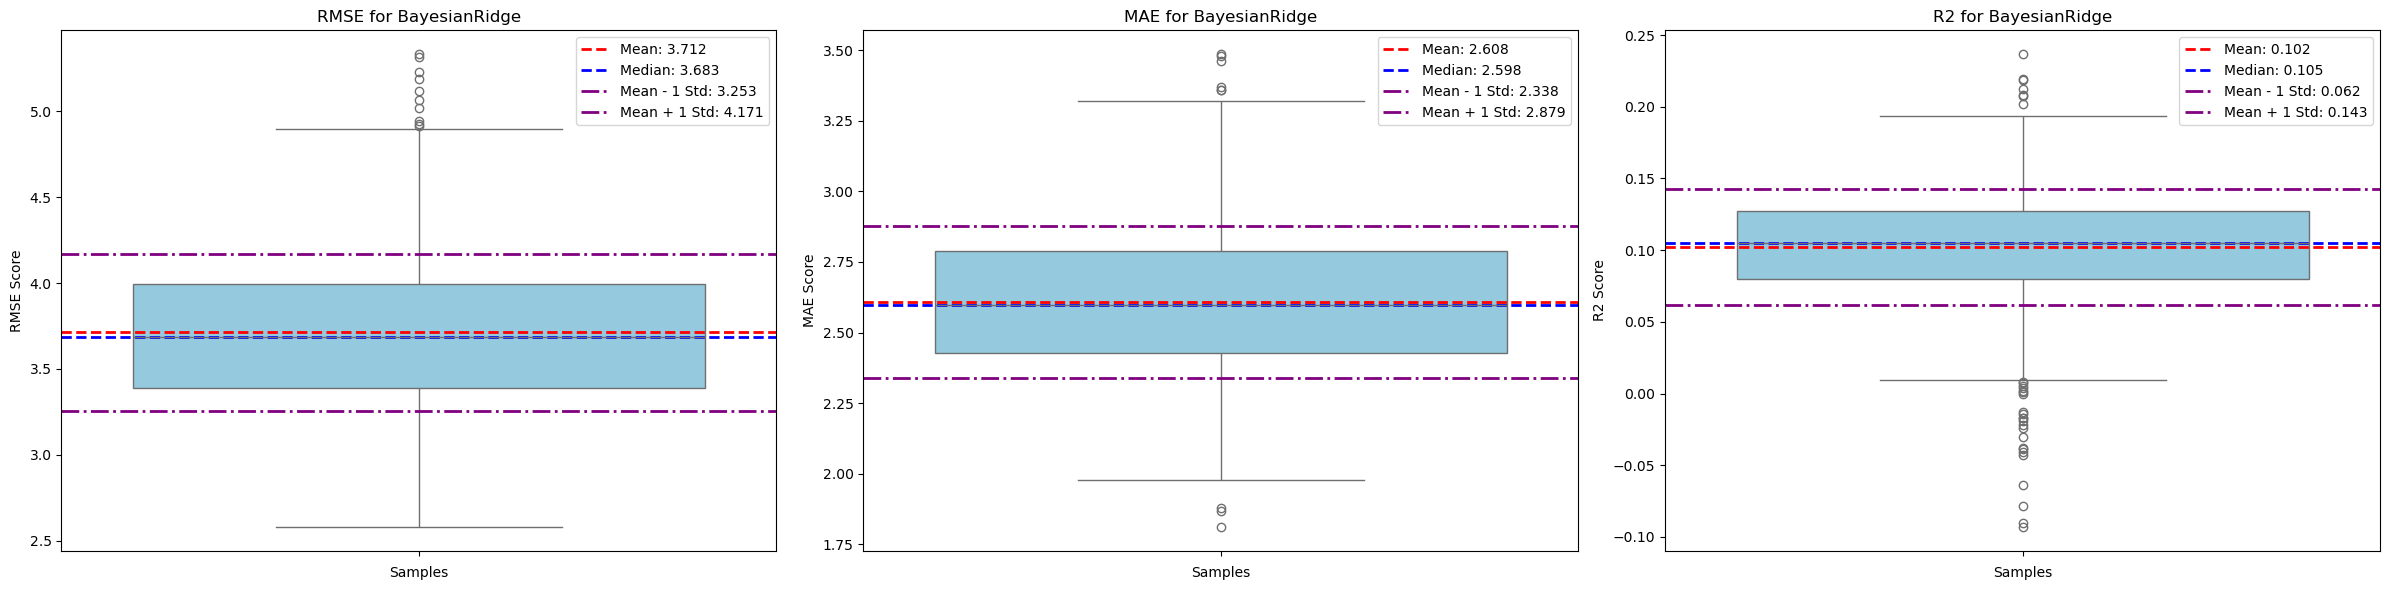

Model: SVR


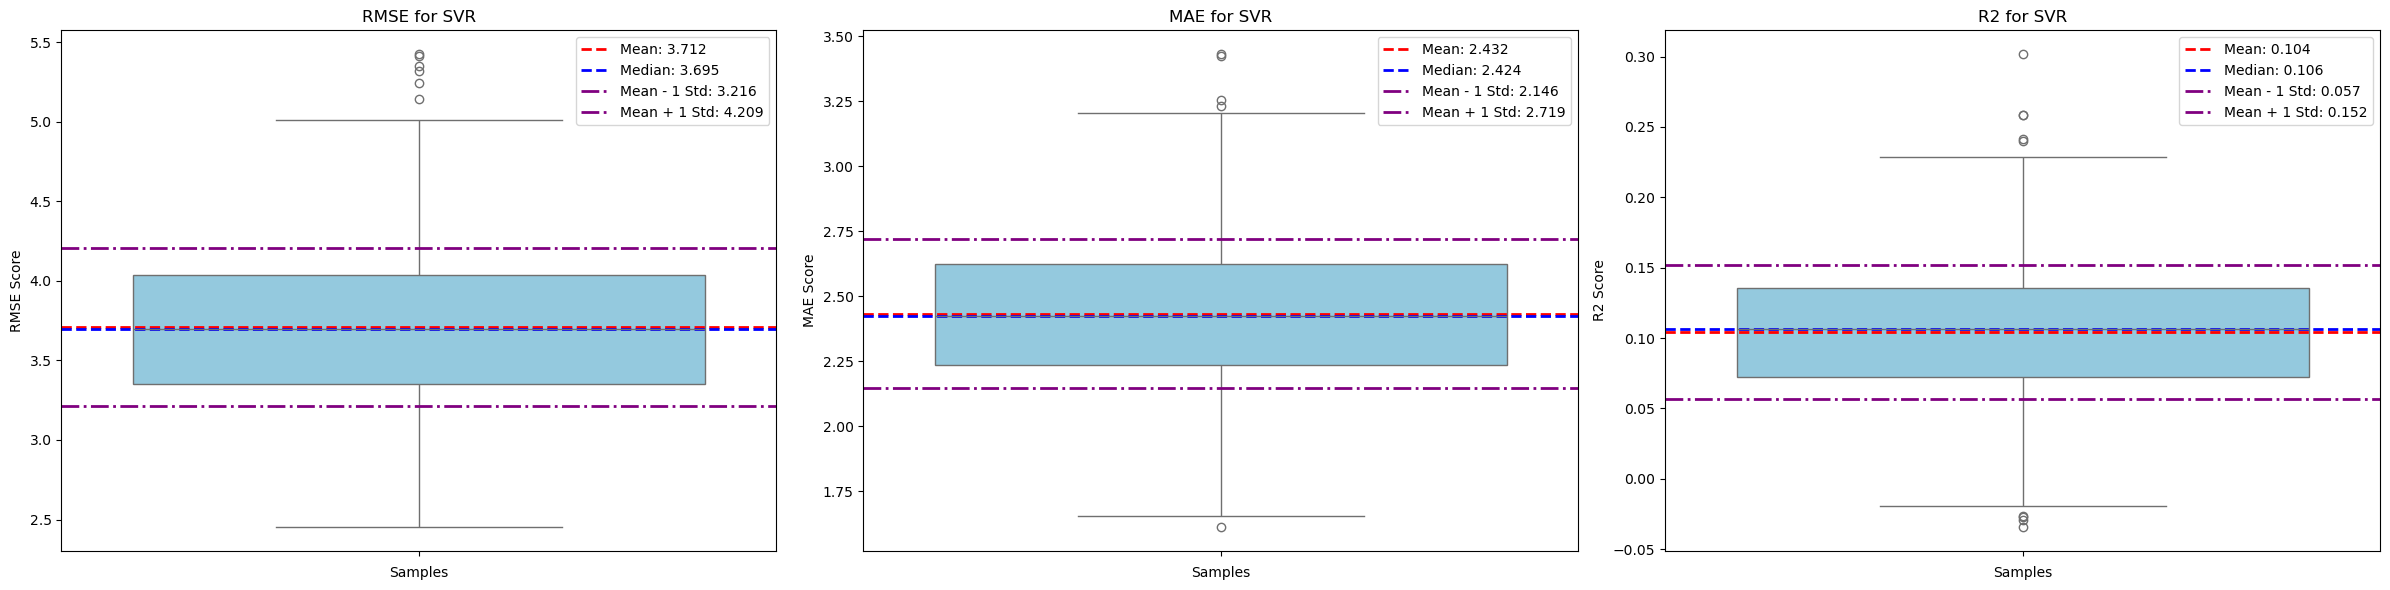

In [11]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))

    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))

    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=90))
    functions.bootstrap2boxplot(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False, save=False)



<hr>

#### **Sequential Feature Selection**

<p>SFS is used below with the number of features being set to 50. A variety of other options were tested ranging from 10 up to 50 features and since a plateu in terms of performance was not reached, we decided to keep 50 features in order to attempt to avoid overfitting.</p>

Model: ElasticNet


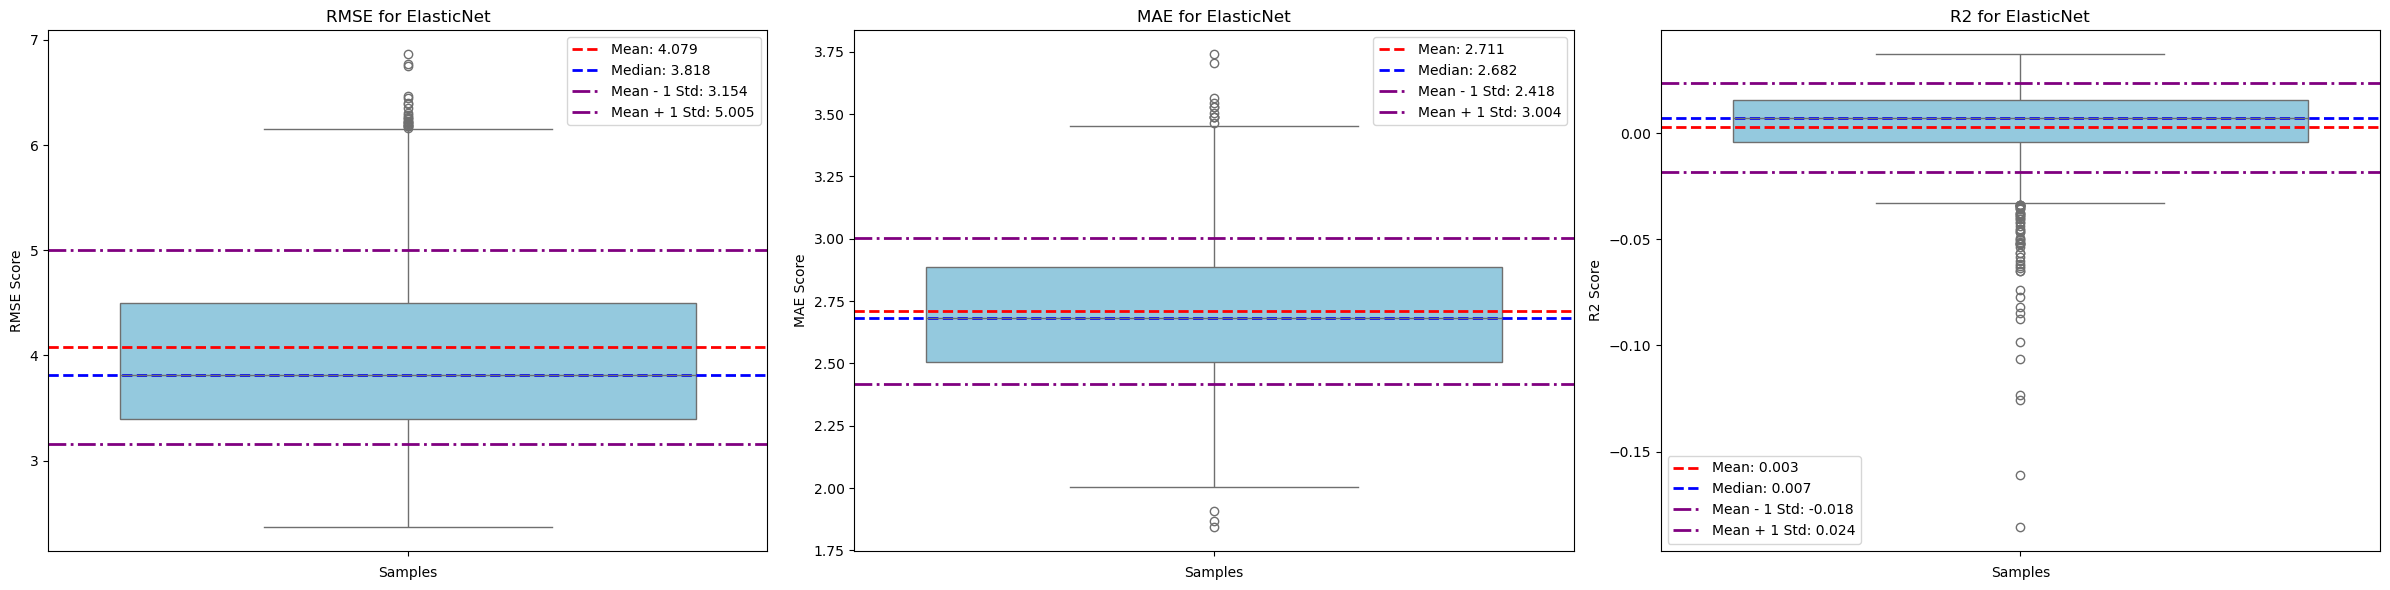

Model: BayesianRidge


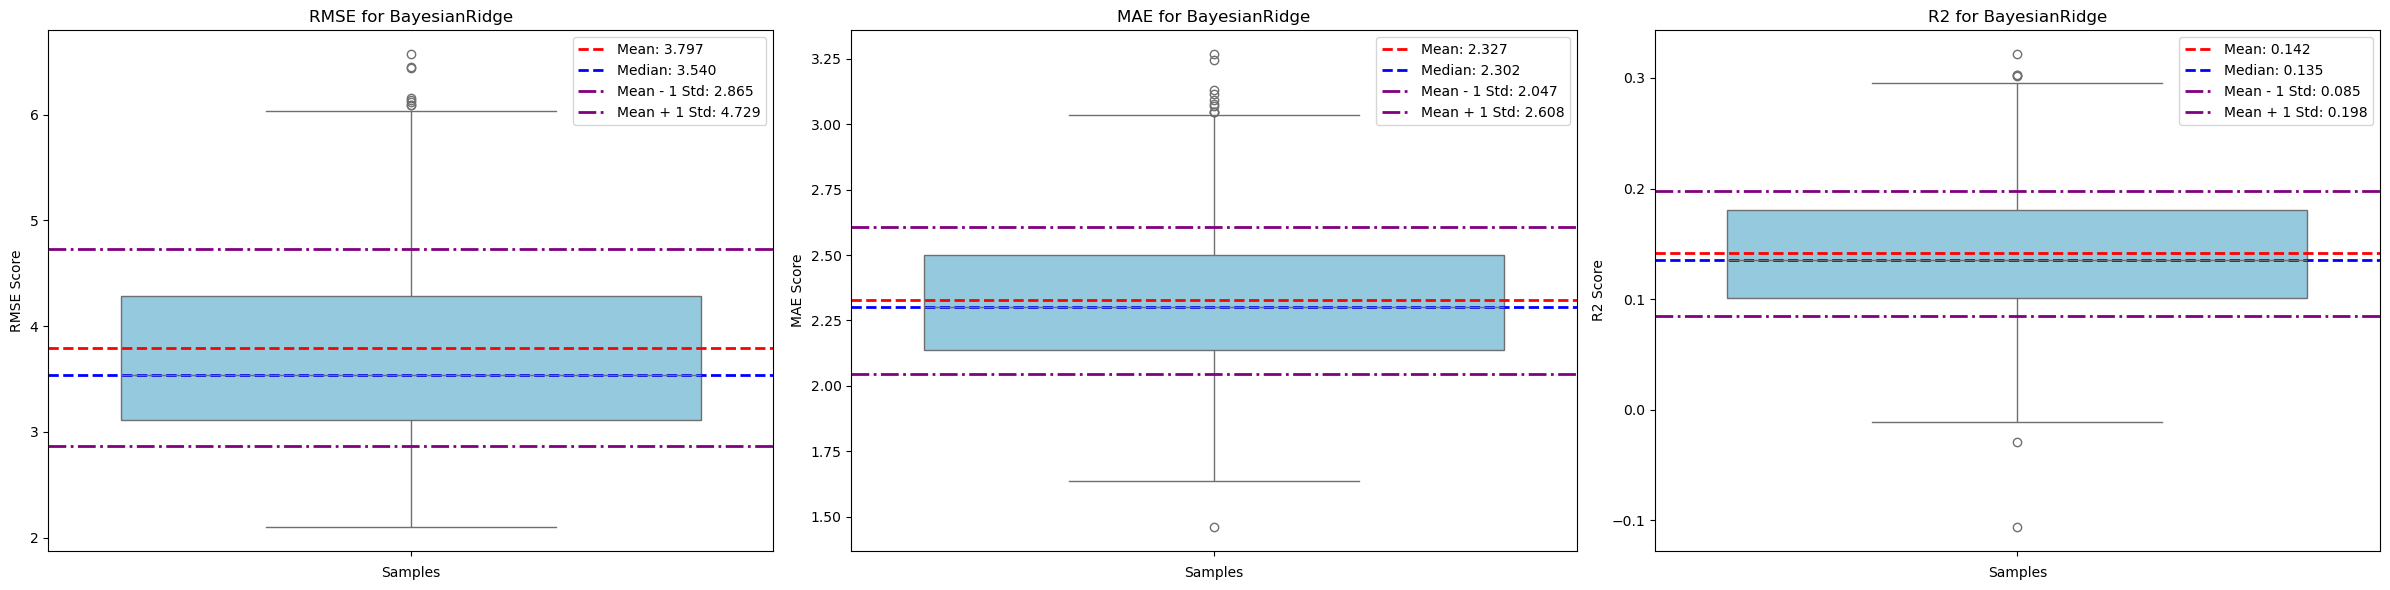

Model: SVR


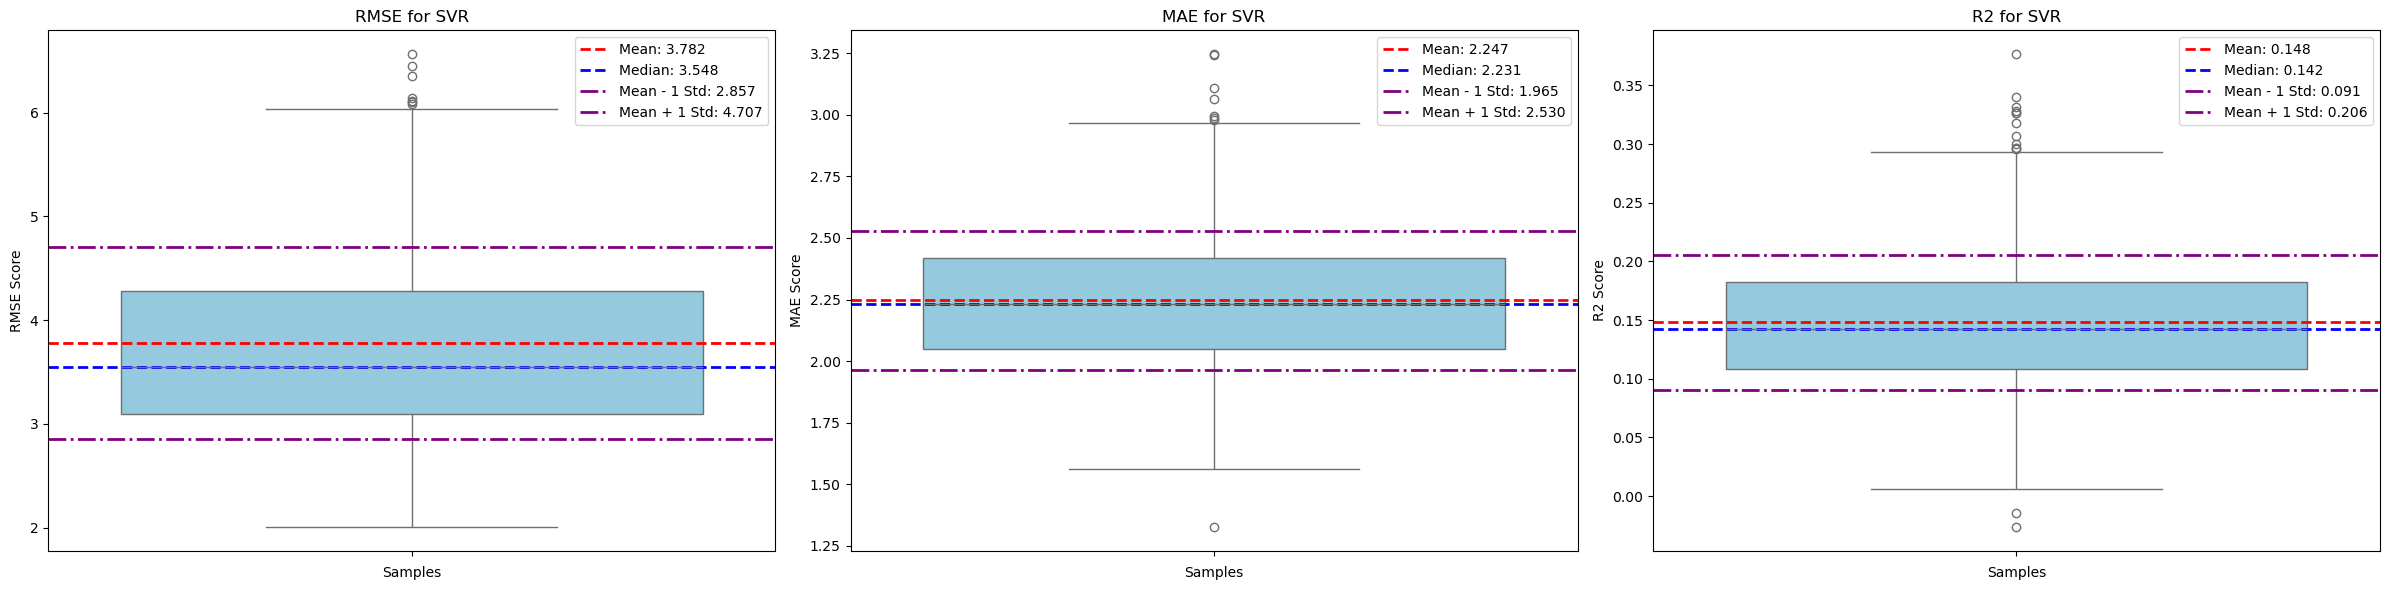

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector
models = [ElasticNet(), BayesianRidge(), SVR()]
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
features_per_model = {}
for model in models:
    print(f"Model: {model.__class__.__name__}")
    sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=50, direction='forward', cv=cv, scoring='neg_root_mean_squared_error')
    sfs.fit(x, y)
    # get_support returns the masks of the selected features
    selected_features = x.columns[sfs.get_support()]
    features_per_model[model.__class__.__name__] = [selected_features]
    x_mod = x[selected_features]
    val_x_mod = val_x[selected_features]
    pipeline = functions.create_pipeline(model, scaler=False, feature_selector=None)
    functions.bootstrap2boxplot(x_mod, y, val_x_mod, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"baseline_{model.__class__.__name__}_sfs.pkl", save=True, default_path=True)
# Save the features per model, ideally a change in format should have been made here
# but it is taken care of in the next cell
with open (root / "data" / "50_features_per_model_sfs.txt", "w") as f:
    for key, value in features_per_model.items():
        f.write(f"{key}: {value}\n")
    

In [13]:
# Modify the format of the features per model to be able to use it in the next cell
with open(root / "data" / "50_features_per_model_sfs.txt", "w") as f:
    for key, value in features_per_model.items():
        features_list = ", ".join(value[0])
        f.write(f"{key}: {features_list}\n")

In [14]:
# Parse the features per model and pass it to a dictionary
features_per_model = {}
with open(root / "data" / "50_features_per_model_sfs.txt", "r") as f:
    for line in f.readlines():
        line = line.strip()
        key, values = line.split(": ")
        values = values.split(", ")
        features_per_model[key] = values
print(features_per_model)
        

{'ElasticNet': ['Acholeplasma axanthum', 'Acidaminococcus fermentans', 'Acidaminococcus intestini', 'Actinomyces lingnae', 'Akkermansia muciniphila', 'Alistipes finegoldii', 'Alistipes indistinctus', 'Alistipes obesi', 'Alistipes onderdonkii', 'Alistipes putredinis', 'Alistipes sp. RMA 9912', 'Alistipes timonensis', 'Anaerofilum pentosovorans', 'Anaerofustis stercorihominis', 'Anaerostipes butyraticus', 'Anaerostipes caccae', 'Bacillus megaterium', 'Bacillus nealsonii', 'Bacteroides eggerthii', 'Bacteroides fragilis', 'Bacteroides gallinarum', 'Bacteroides graminisolvens', 'Bacteroides intestinalis', 'Bacteroides ovatus', 'Bacteroides plebeius', 'Bacteroides salyersiae', 'Barnesiella viscericola', 'Bifidobacterium bifidum', 'Bifidobacterium pseudocatenulatum', 'Bifidobacterium tsurumiense', 'Bilophila wadsworthia', 'Blautia coccoides', 'Blautia glucerasea', 'Blautia hydrogenotrophica', 'Blautia producta', 'Blautia schinkii', 'Catabacter hongkongensis', 'Clostridium malenominatum', 'Clo

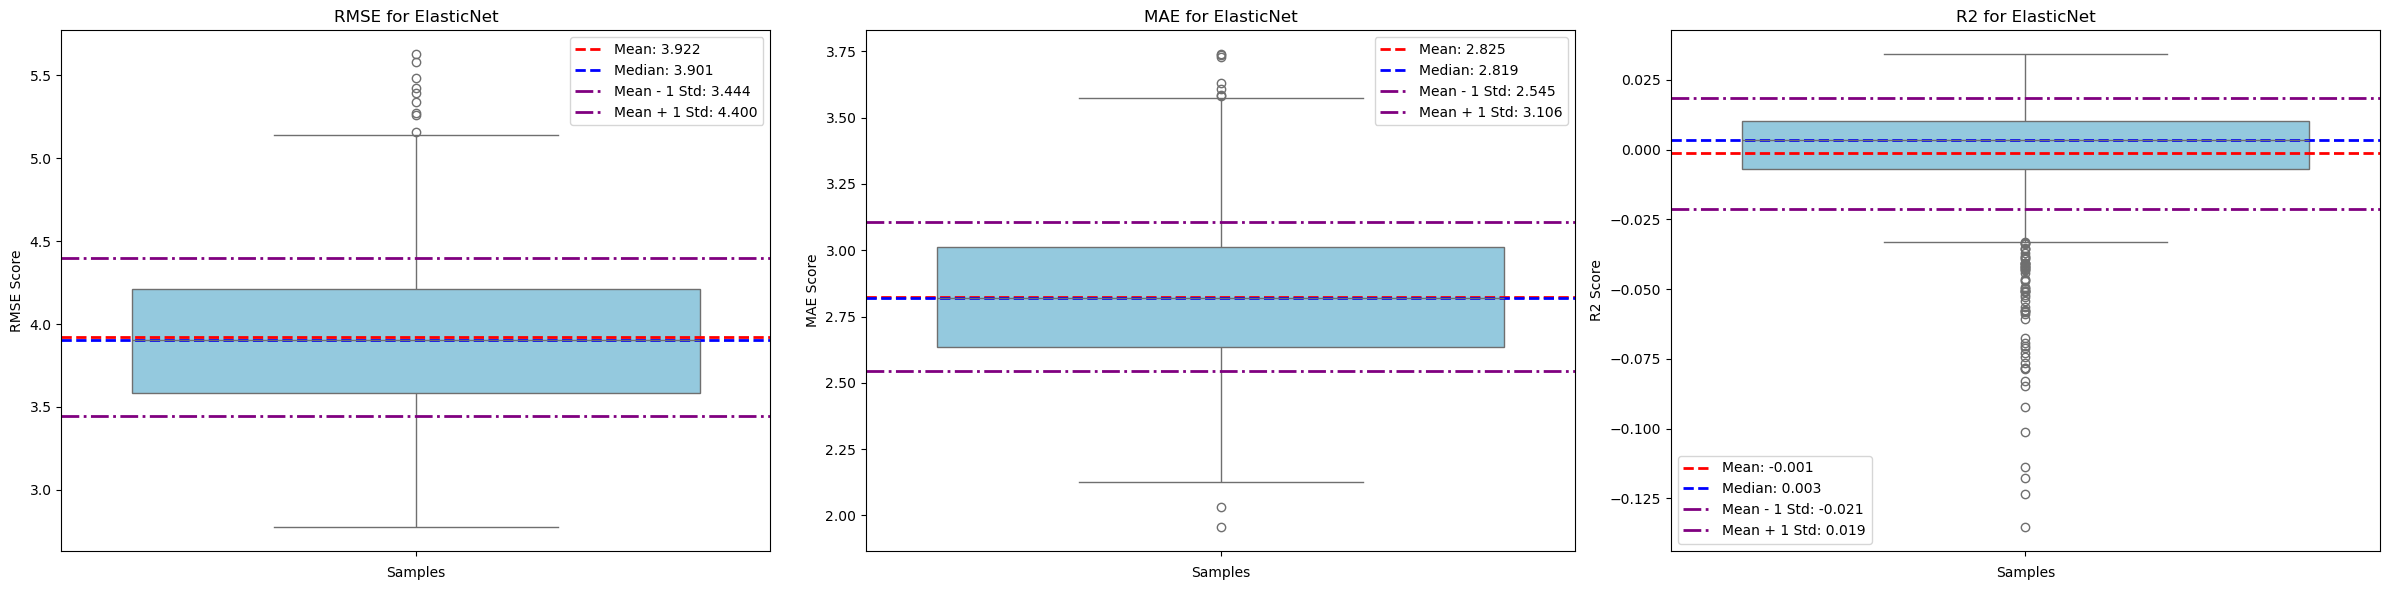

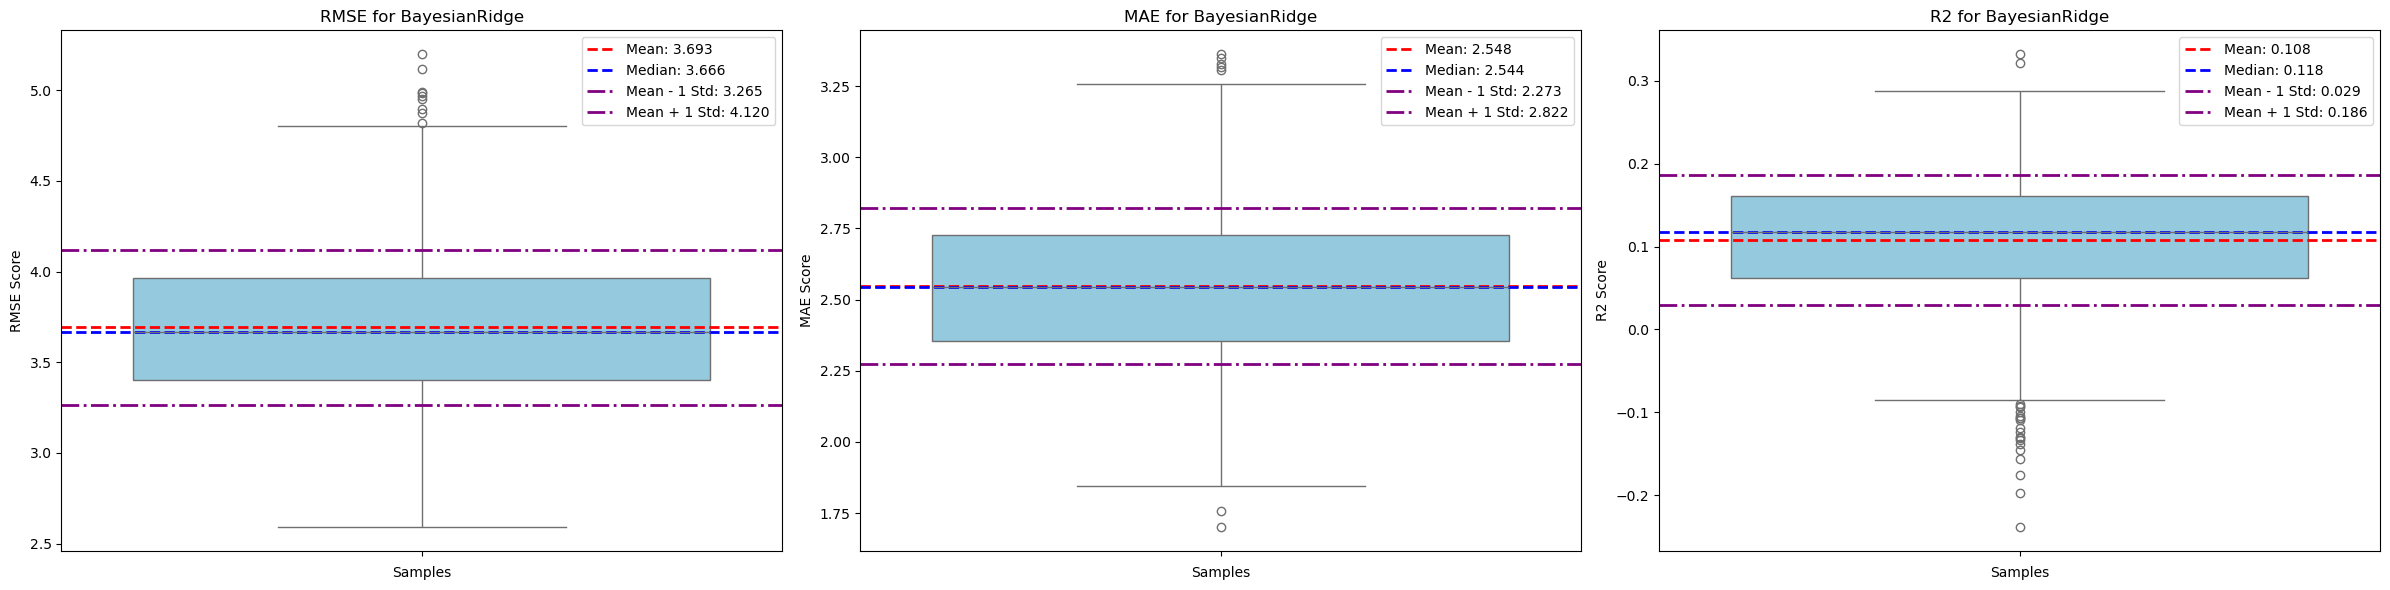

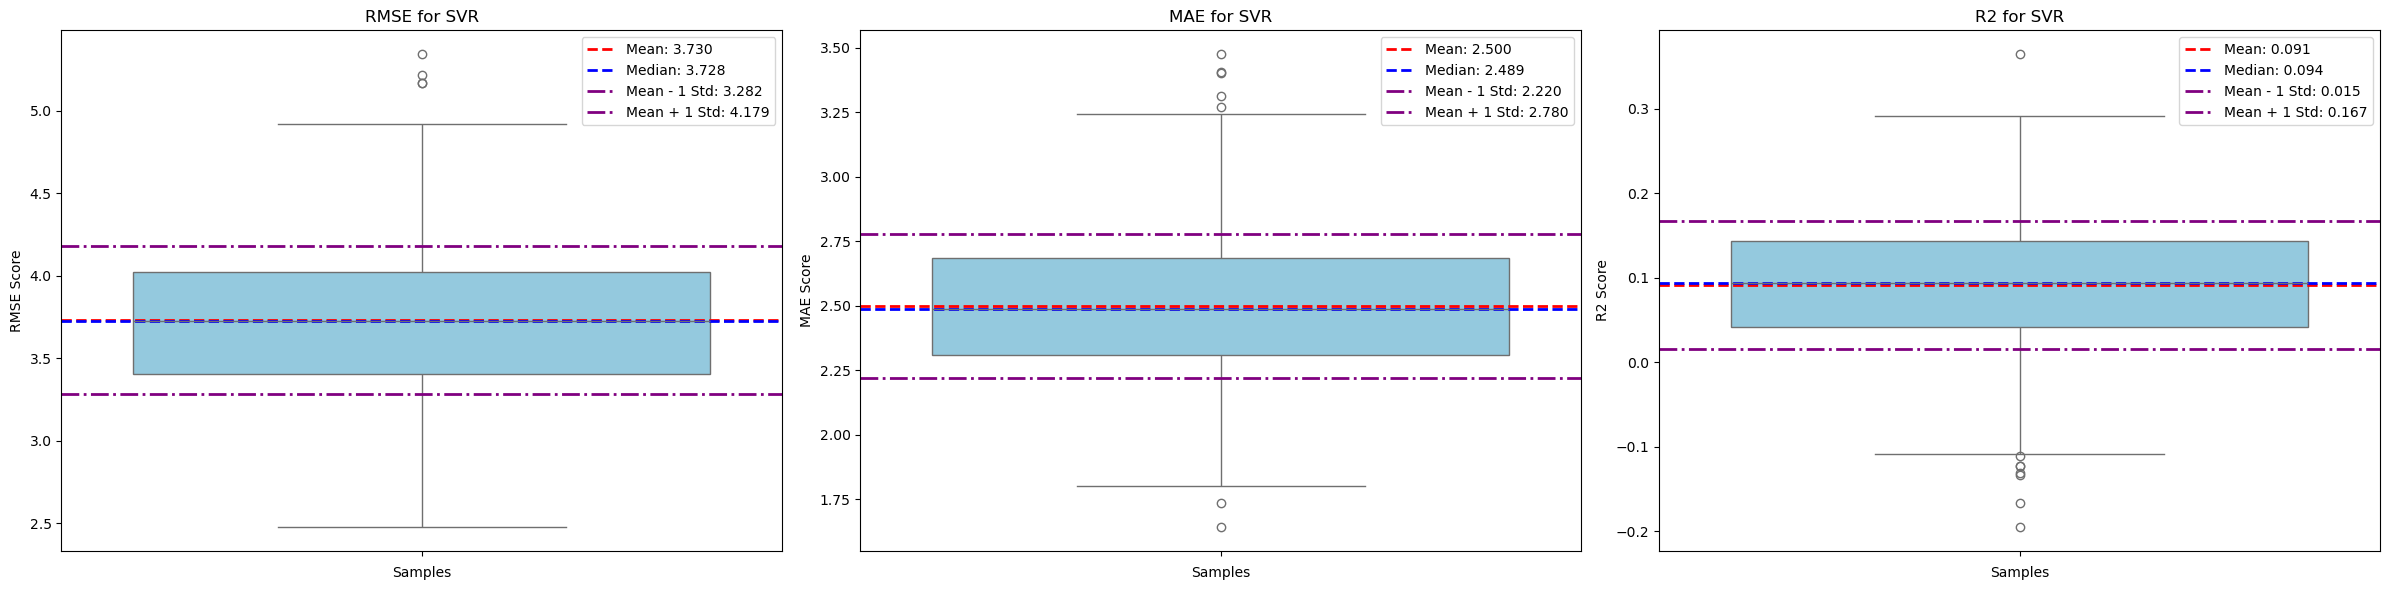

In [15]:
# Run Evaluation with bootstrap and plot the results
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    mod_x = x[features_per_model[model.__class__.__name__]]
    val_x_mod = val_x[features_per_model[model.__class__.__name__]]
    pipeline = functions.create_pipeline(model, scaler=False, feature_selector=None)
    functions.bootstrap2boxplot(mod_x, y, val_x_mod, val_y, pipeline, n_iter=1000, bstrap=True, kf=False, save=False)

<p>As we can see, the metrics based on evaluation with bootstrapping seem to be of lower quality than those in Kfold Cross-Validation. More specifically, the RMSE and MAE have increased and the R2 score has decreased which indicate a drop in the generalization capability. This is likely due to the fact that the dataset is rather small and thus SFS leads to overfitting by choosing features based on the minimization of RMSE. Improvement could be seen if the number of features is increased</p>

<hr>

## Fine-tuning

<p>After performing feature selection, we used Optuna to perform fine-tuning on the hyperparameters of the three algorithms with the objective of maximizing the negative root mean squared error (RMSE). For each algorithm, we used the following search space:</p>

1. **ElasticNet**:
    - alpha: [0.1, 10]
    - l1_ratio: [0.1, 10]

2. **BayesianRidge**:
    - alpha_1: [1e-8, 1e-4]
    - lambda_1: [1e-8, 1e-4]
    - alpha_2: [1e-8, 1e-4]
    - lambda_2: [1e-8, 1e-4]

3. **SVR**:
    - C: [0.1, 10]
    - epsilon: [0.01, 1]
    - gamma: ['scale', 'auto']
    - kernel: ['linear', 'poly', 'rbf']
    - degree: [2, 5]
    - coef0: [0, 1]



In [16]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))
    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=94))
    study = optuna.create_study(direction="maximize")
    # I had to use chatgpt for the following line, to figure out how to pass the model and x and y to the optuna_objective function
    study.optimize(lambda trial: functions.optuna_objective(trial, model, x, y, pipeline), n_trials=100)
    # Best hyperparameters
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
            print(f"    {key}: {value}")

[I 2025-04-10 15:07:06,250] A new study created in memory with name: no-name-7effdf73-0527-43fc-aa1f-8ae023bc4af8


Model: ElasticNet


[I 2025-04-10 15:07:07,167] Trial 0 finished with value: -4.117101733388933 and parameters: {'alpha': 8.22624009906325, 'l1_ratio': 0.7862382048310553}. Best is trial 0 with value: -4.117101733388933.
[I 2025-04-10 15:07:07,981] Trial 1 finished with value: -4.117101733388933 and parameters: {'alpha': 6.5677805136098915, 'l1_ratio': 0.5332834617305213}. Best is trial 0 with value: -4.117101733388933.
[I 2025-04-10 15:07:08,642] Trial 2 finished with value: -4.117101733388933 and parameters: {'alpha': 7.637288245051981, 'l1_ratio': 0.8207120736358586}. Best is trial 0 with value: -4.117101733388933.
[I 2025-04-10 15:07:09,342] Trial 3 finished with value: -4.117101733388933 and parameters: {'alpha': 5.148374414958135, 'l1_ratio': 0.5596929383680516}. Best is trial 0 with value: -4.117101733388933.
[I 2025-04-10 15:07:09,976] Trial 4 finished with value: -4.117101733388933 and parameters: {'alpha': 8.01432883303253, 'l1_ratio': 0.3069516774406197}. Best is trial 0 with value: -4.11710173

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -4.0072407881705585
  Params: 
    alpha: 1.1532018477809582
    l1_ratio: 0.015803387025468296
Model: BayesianRidge


[I 2025-04-10 15:08:13,247] Trial 0 finished with value: -4.020768328505156 and parameters: {'alpha_1': 1.6405658748321671e-07, 'lambda_1': 4.522012385568256e-07, 'alpha_2': 2.0400746451921503e-06, 'lambda_2': 7.579342662735281e-07}. Best is trial 0 with value: -4.020768328505156.
[I 2025-04-10 15:08:14,031] Trial 1 finished with value: -4.020715235491931 and parameters: {'alpha_1': 1.545550212351634e-06, 'lambda_1': 8.48806640158313e-05, 'alpha_2': 1.399735454660659e-06, 'lambda_2': 7.301193932186146e-05}. Best is trial 1 with value: -4.020715235491931.
[I 2025-04-10 15:08:14,760] Trial 2 finished with value: -4.020764082144689 and parameters: {'alpha_1': 3.310763607632629e-08, 'lambda_1': 7.208514052947765e-05, 'alpha_2': 3.973738579183829e-05, 'lambda_2': 7.2019142463465456e-06}. Best is trial 1 with value: -4.020715235491931.
[I 2025-04-10 15:08:15,518] Trial 3 finished with value: -4.020748200043615 and parameters: {'alpha_1': 3.870757971032719e-05, 'lambda_1': 1.643870158321341e-

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -4.020694005815398
  Params: 
    alpha_1: 1.451447299600408e-05
    lambda_1: 8.45627286418228e-08
    alpha_2: 1.9342297272095466e-06
    lambda_2: 9.99445377972201e-05
Model: SVR


[I 2025-04-10 15:09:35,168] Trial 0 finished with value: -3.962499635467275 and parameters: {'C': 7.274400035427418, 'gamma': 'auto', 'epsilon': 0.4301532973839986, 'kernel': 'rbf'}. Best is trial 0 with value: -3.962499635467275.
[I 2025-04-10 15:09:36,723] Trial 1 finished with value: -4.008423606745591 and parameters: {'C': 0.8093011433532388, 'gamma': 'auto', 'epsilon': 0.8272006217895734, 'kernel': 'rbf'}. Best is trial 0 with value: -3.962499635467275.
[I 2025-04-10 15:09:38,276] Trial 2 finished with value: -4.077065399201271 and parameters: {'C': 3.3702088588241974, 'gamma': 'scale', 'epsilon': 0.1539444921826106, 'kernel': 'poly', 'degree': 2, 'coef0': 0.9570978654746474}. Best is trial 0 with value: -3.962499635467275.
[I 2025-04-10 15:09:56,481] Trial 3 finished with value: -4.201704001812422 and parameters: {'C': 1.7332492902051013, 'gamma': 'auto', 'epsilon': 0.5693379278487057, 'kernel': 'linear'}. Best is trial 0 with value: -3.962499635467275.
[I 2025-04-10 15:09:57,850

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -3.931101129052292
  Params: 
    C: 3.9290765618121544
    gamma: scale
    epsilon: 0.06466478710466253
    kernel: rbf


#### **The suggested parameters for the three models are as follows:**
(similar to the first run where scaler was not handled properly)
1. **ElasticNet**:
    - alpha: 1.1532018477809582
    - l1_ratio: 0.015803387025468296

2. **BayesianRidge**:
    - alpha_1: 1.451447299600408e-05
    - lambda_1: 8.45627286418228e-08
    - alpha_2: 1.9342297272095466e-06
    - lambda_2: 9.99445377972201e-05

3. **SVR**:
    - C: 3.9290765618121544
    - gamma: scale
    - epsilon: 0.06466478710466253
    - kernel: rbf

<p>After fine-tuning, we performed kfold-cross validation and evaluation and plotted the results as before to be able to compare the performance of our fine-tuned models with the baseline models.</p>


ElasticNet


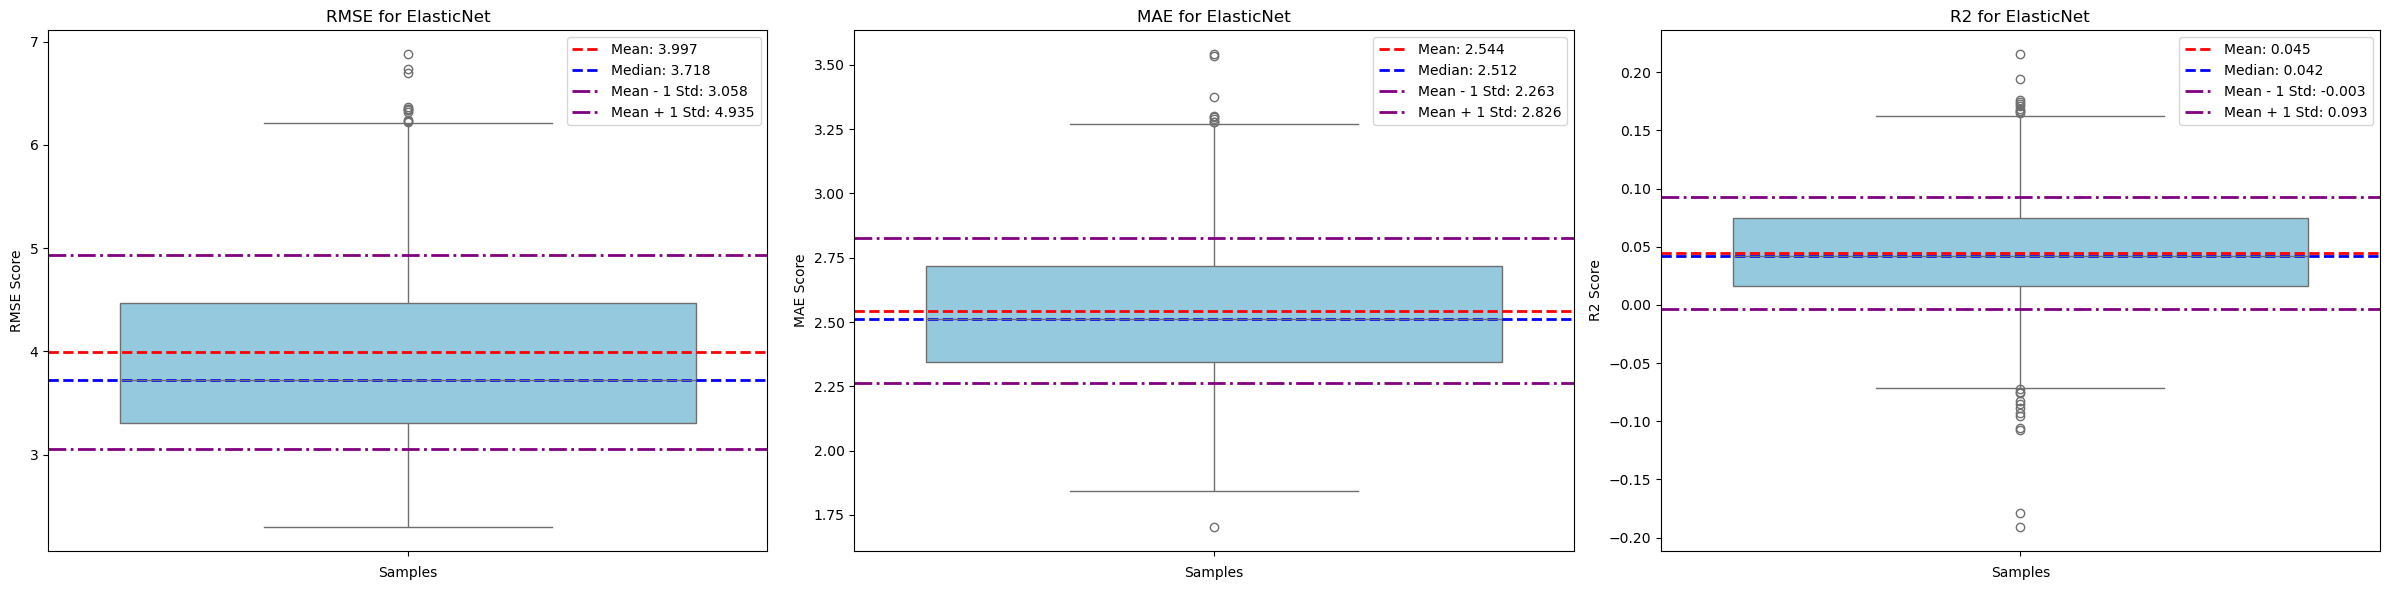

BayesianRidge


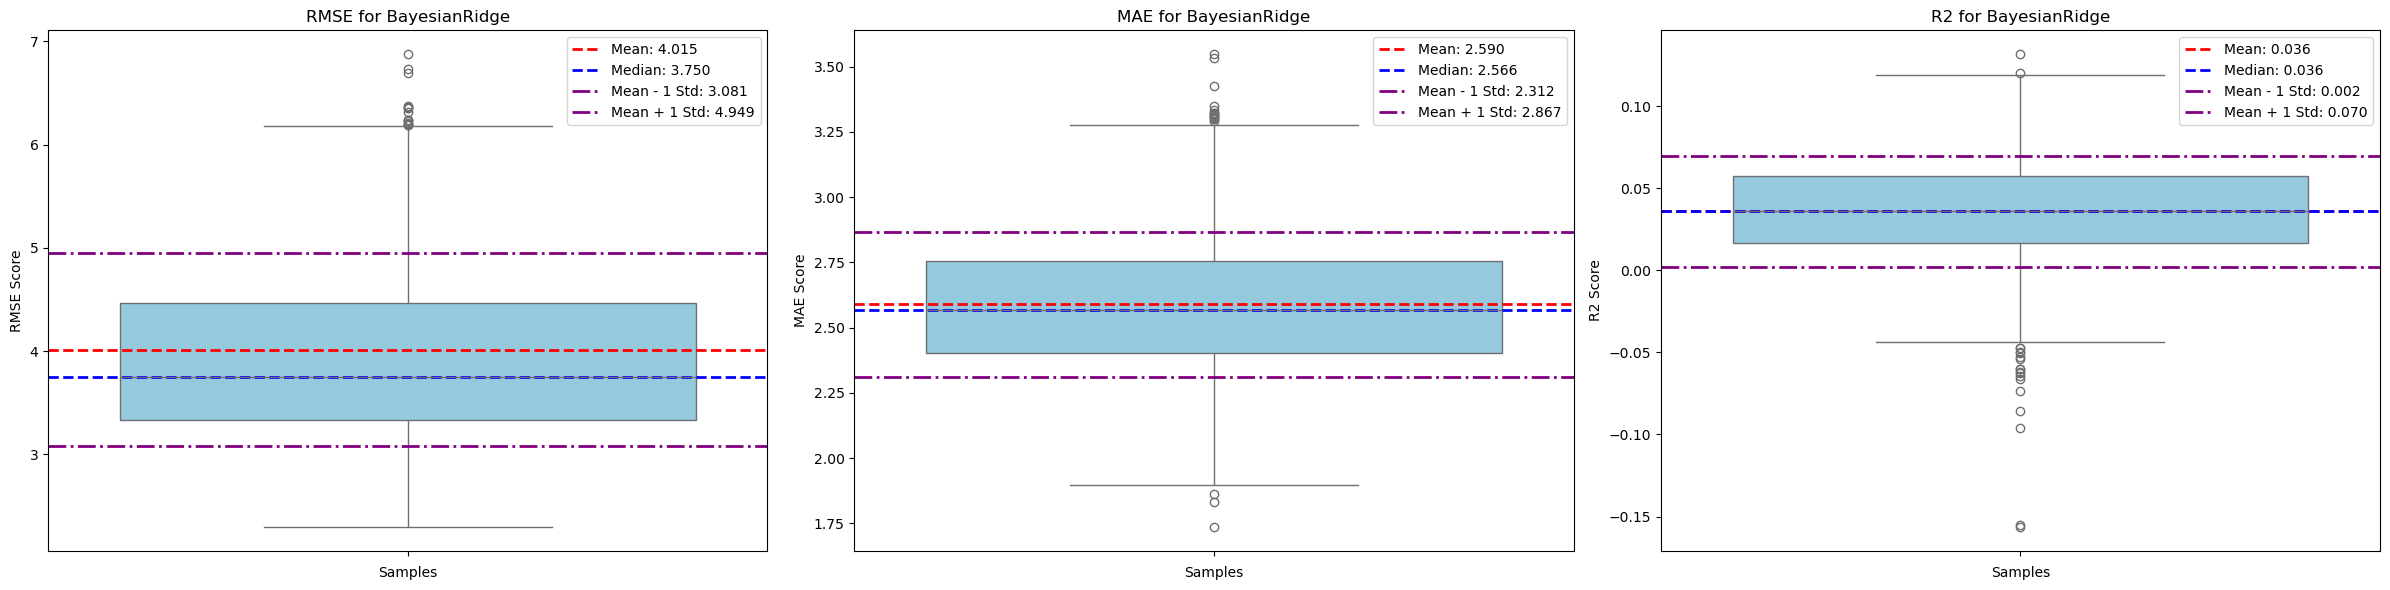

SVR


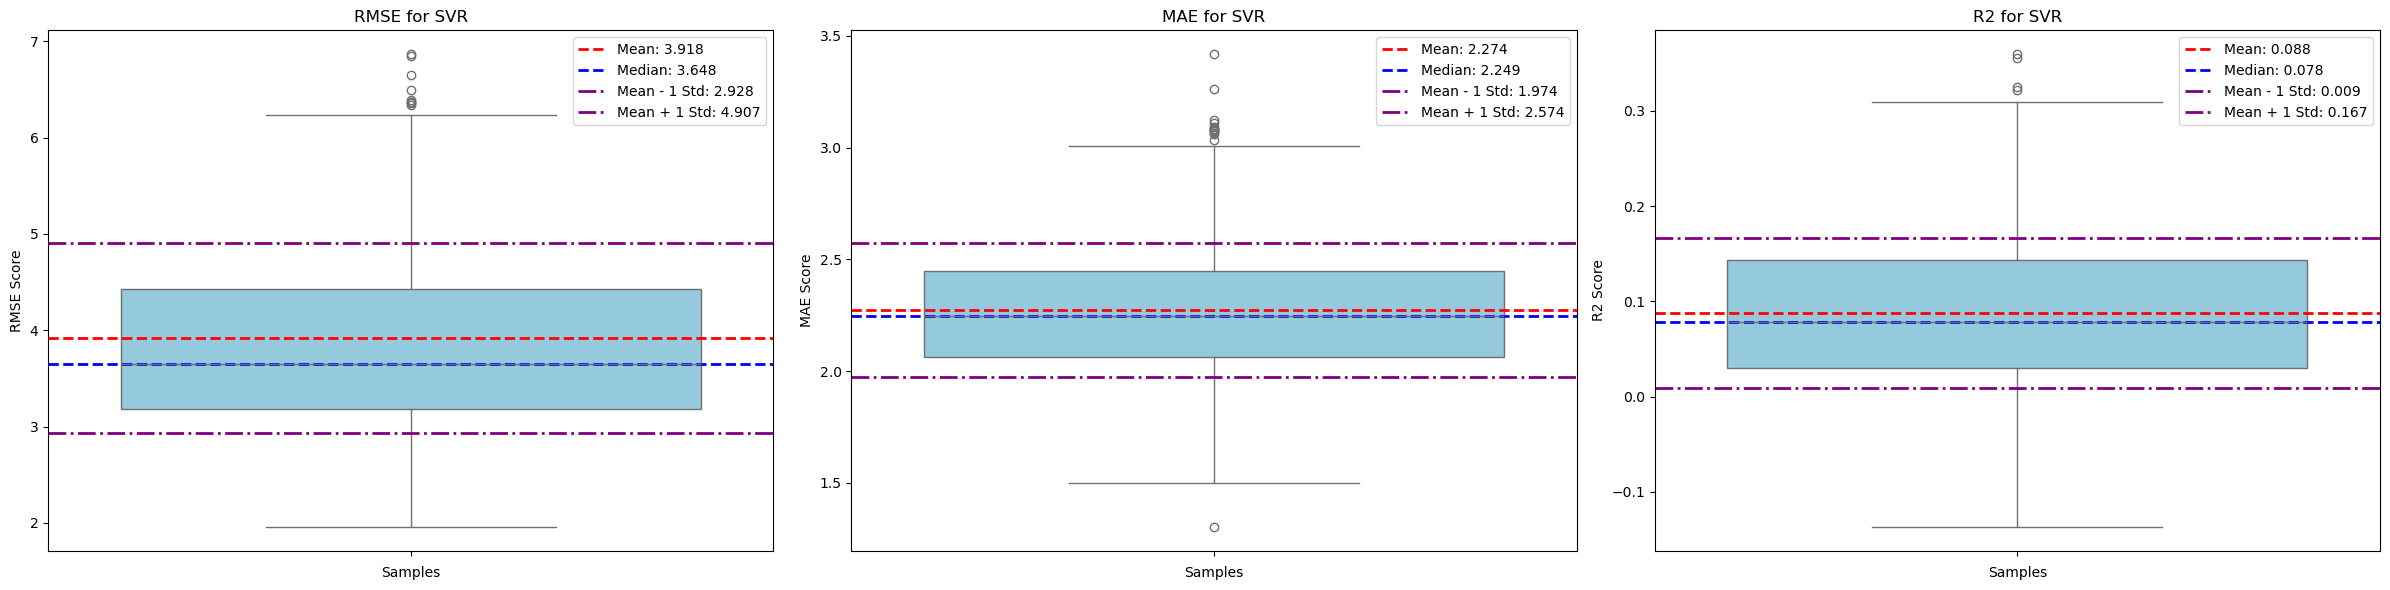

In [17]:
models = [ElasticNet(alpha=1.1532018477809582, l1_ratio=0.015803387025468296), BayesianRidge(alpha_1=1.451447299600408e-05, alpha_2=1.9342297272095466e-06, lambda_1=8.45627286418228e-08, lambda_2=9.99445377972201e-05), SVR(C=3.9290765618121544, gamma='scale', epsilon=0.06466478710466253, kernel='rbf')]
for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))
    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=94))
    functions.bootstrap2boxplot(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f"{model.__class__.__name__}_optuna_pca.pkl", save=True, default_path=True)

ElasticNet


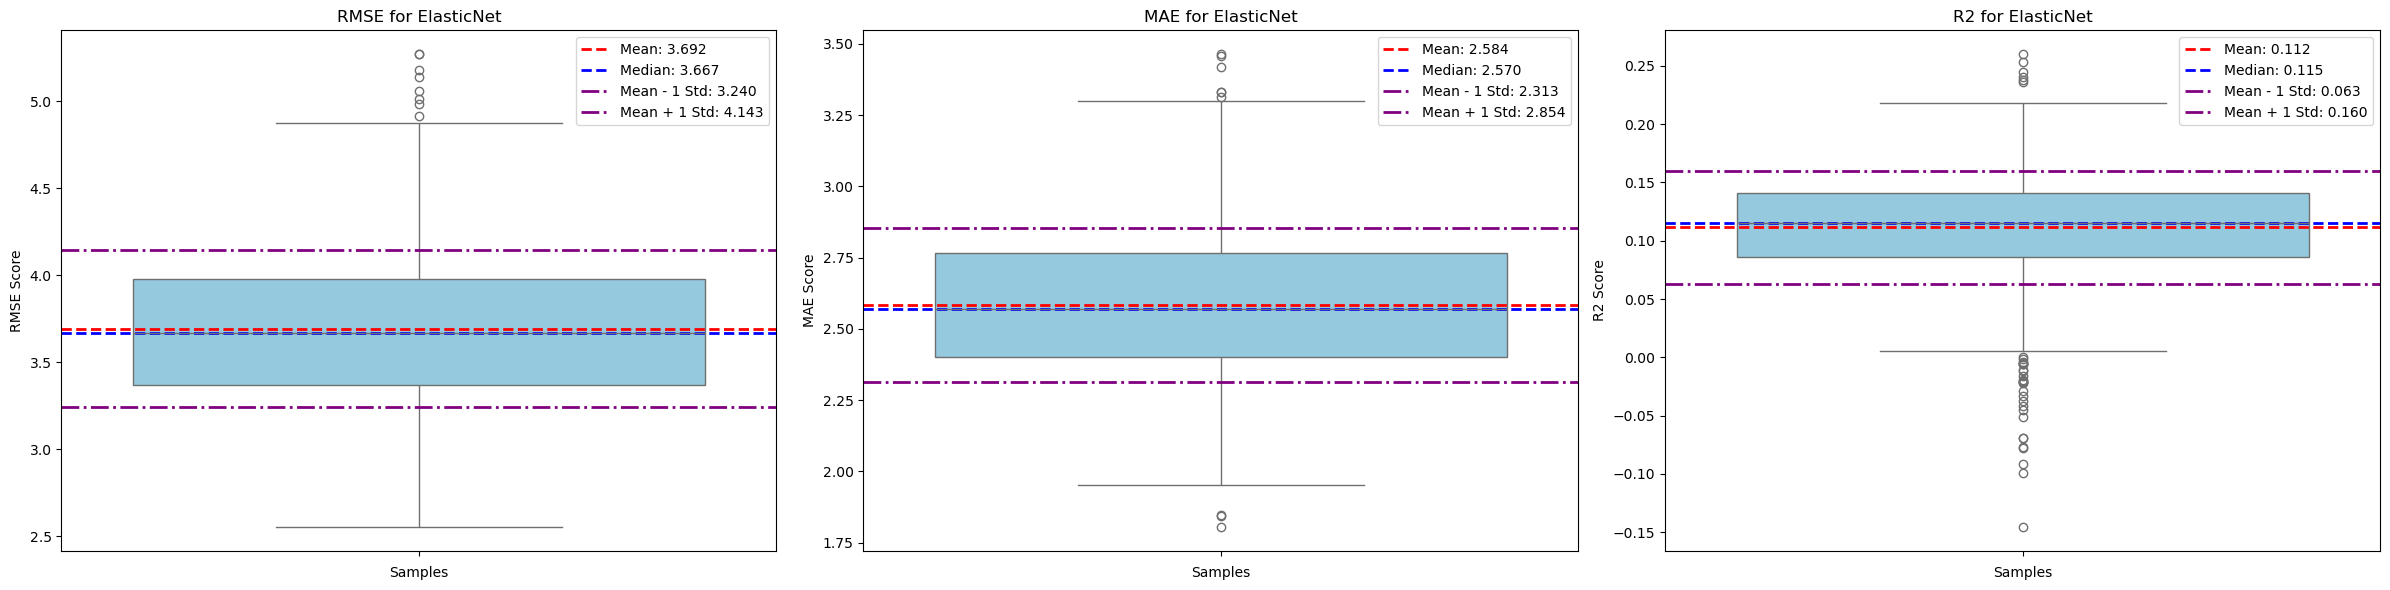

BayesianRidge


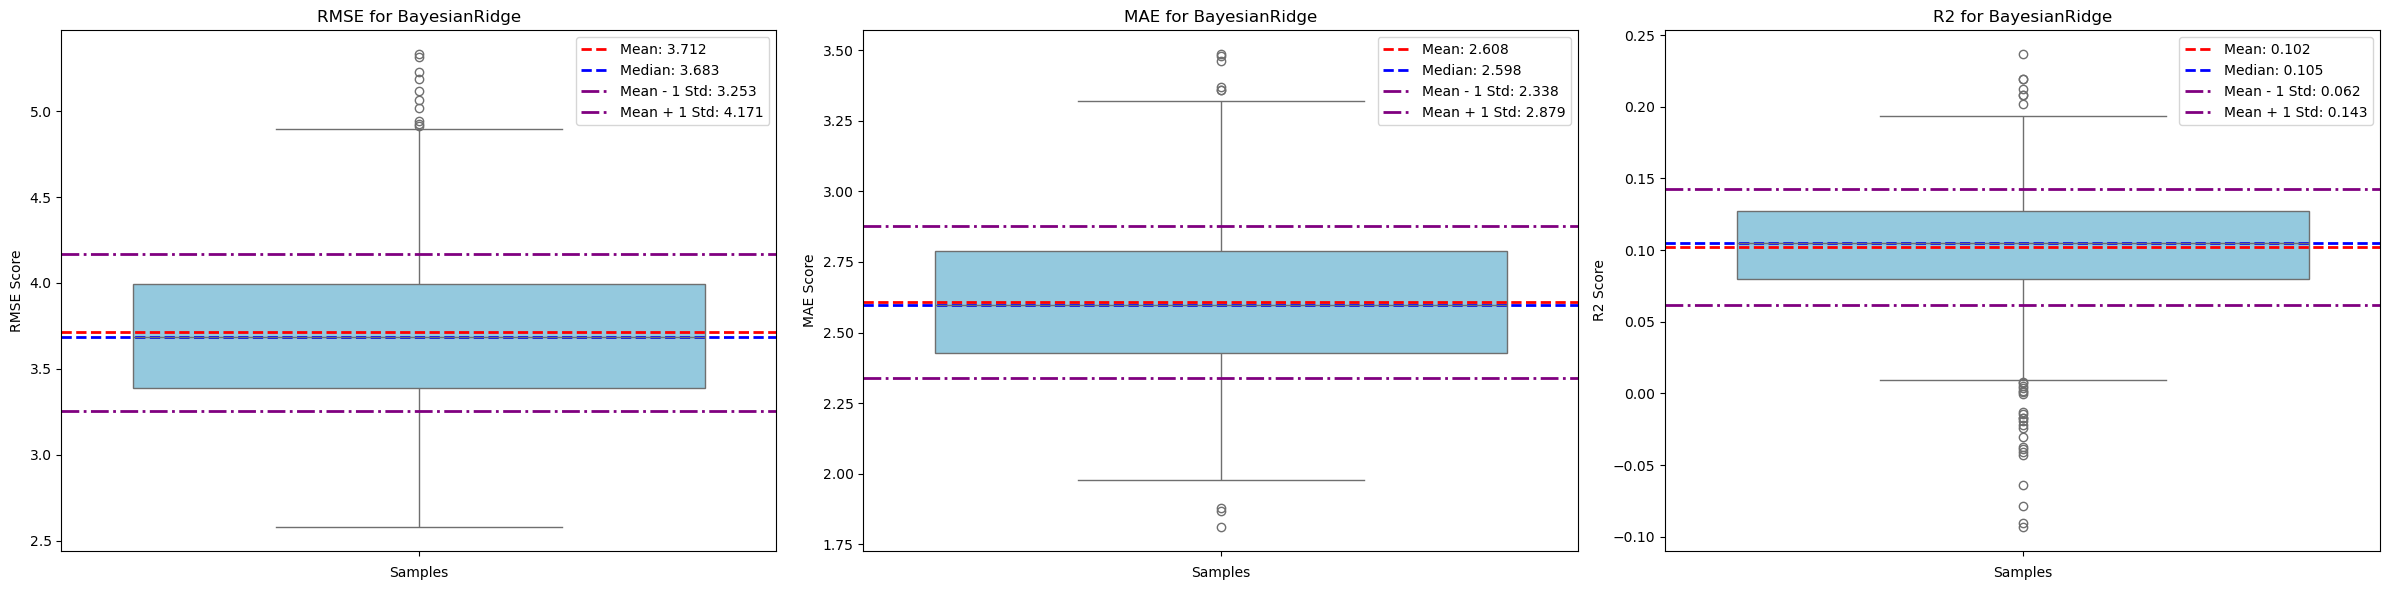

SVR


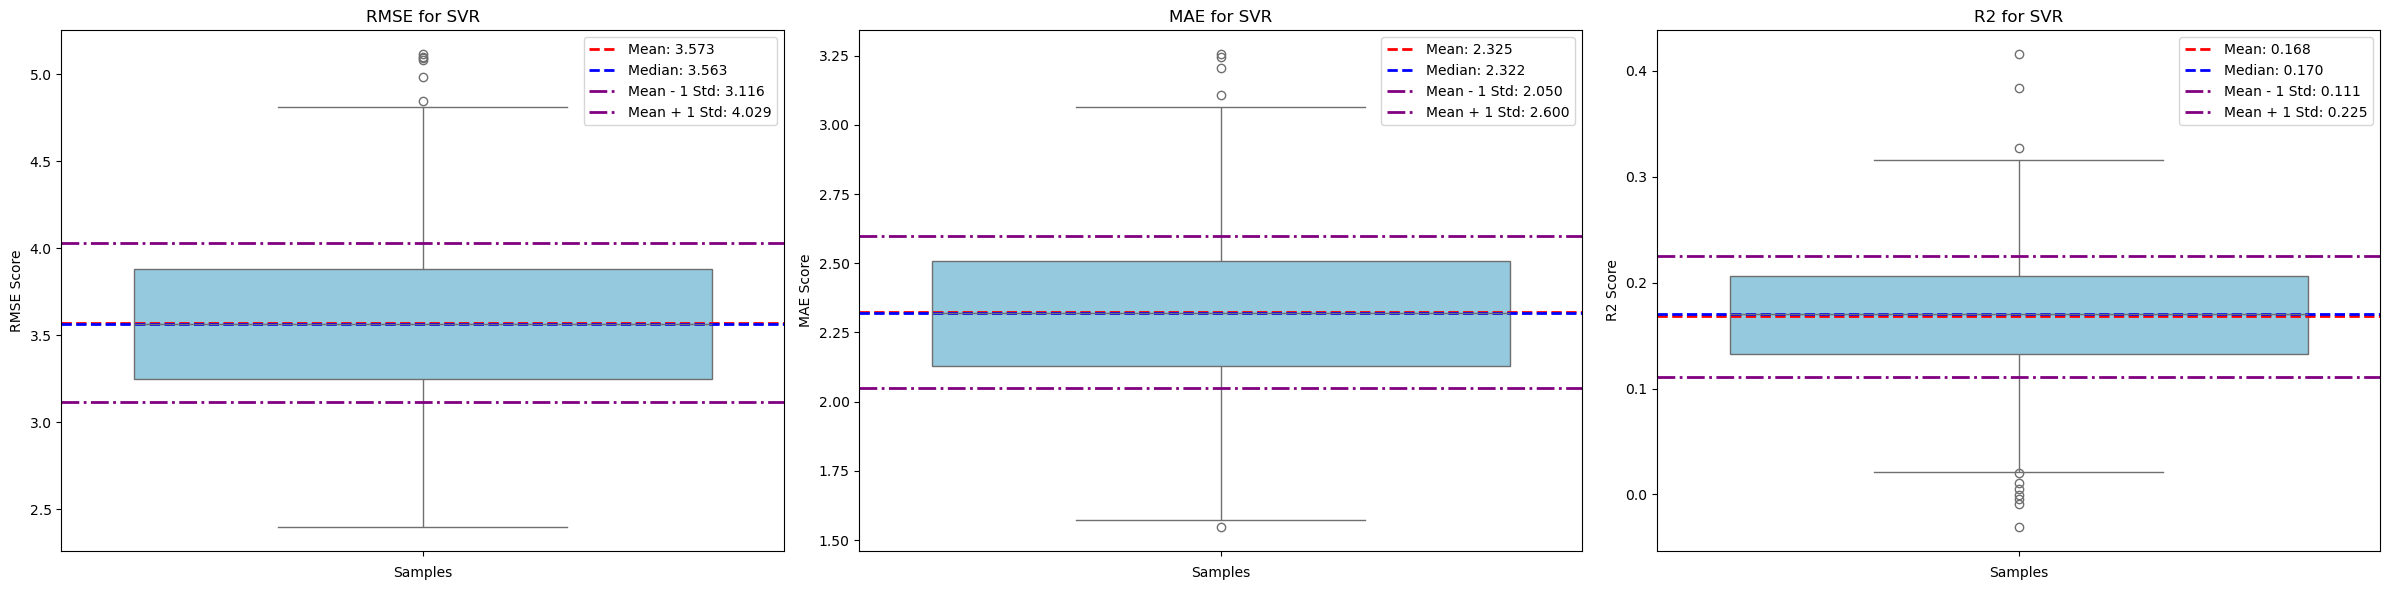

In [18]:
models = [ElasticNet(alpha=1.1532018477809582, l1_ratio=0.015803387025468296), BayesianRidge(alpha_1=1.451447299600408e-05, alpha_2=1.9342297272095466e-06, lambda_1=8.45627286418228e-08, lambda_2=9.99445377972201e-05), SVR(C=3.9290765618121544, gamma='scale', epsilon=0.06466478710466253, kernel='rbf')]
for model in models:
    print(model.__class__.__name__)
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))
    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=47))
    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=94))
    functions.bootstrap2boxplot(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False, save=False)

<p>The boxplots show that fine-tuning did not significantly improve the performance of the models. ElasticNet and Bayesian Ridge have remained largely the same whereas SVR has only slightly improved in terms of R2. These results indicate that these models are likely overfitted, especially when only utilizing microbiome data.</p>

<hr>

#### **Fine Tuning on Sequential Feature Selection**

<p>Although this feature selection technique led to overfitting based on the results of the evaluation process, it was deemed worth to try fine-tuning based on the set of selected features. Naturally, although the results based on the kfold cross-validation were the best, the results based on bootstrapping fell short in comparison to PCA based feature selection, but are still significantly better than the baseline. This is expected since overfitting was observed in the evaluation of the baseline models trained on these features.</p>

In [4]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
# Run Optuna optimization
    print(f"Running Optuna optimization for {model.__class__.__name__}...")
    if model.__class__.__name__ in features_per_model.keys():
        x_mod = x[features_per_model[model.__class__.__name__]]
        study = optuna.create_study(direction="maximize")
        # I had to use chatgpt for the following line, to figure out how to pass the model and x and y to the optuna_objective function
        study.optimize(lambda trial: functions.optuna_objective(trial, model, x_mod, y), n_trials=100)
        # Best hyperparameters
        print("Study statistics: ")
        print("  Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
                print(f"    {key}: {value}")

[I 2025-03-22 15:30:11,796] A new study created in memory with name: no-name-c2d8242b-3992-4021-ad2c-d7fd01acb9b3


Running Optuna optimization for ElasticNet...


[I 2025-03-22 15:30:12,057] Trial 0 finished with value: -4.117101733388933 and parameters: {'alpha': 4.287733652947066, 'l1_ratio': 0.6527895397514297}. Best is trial 0 with value: -4.117101733388933.
[I 2025-03-22 15:30:12,225] Trial 1 finished with value: -4.117101733388933 and parameters: {'alpha': 5.168241353626595, 'l1_ratio': 0.5609272717119251}. Best is trial 0 with value: -4.117101733388933.
[I 2025-03-22 15:30:12,475] Trial 2 finished with value: -4.113739473746942 and parameters: {'alpha': 1.0012361217313974, 'l1_ratio': 0.7285557361116889}. Best is trial 2 with value: -4.113739473746942.
[I 2025-03-22 15:30:12,660] Trial 3 finished with value: -4.117101733388933 and parameters: {'alpha': 9.770659059915024, 'l1_ratio': 0.6060009852217684}. Best is trial 2 with value: -4.113739473746942.
[I 2025-03-22 15:30:12,869] Trial 4 finished with value: -3.9921285259729147 and parameters: {'alpha': 0.3912828083456691, 'l1_ratio': 0.6650160944794075}. Best is trial 4 with value: -3.9921

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -3.9785465678318688
  Params: 
    alpha: 0.3974487856623652
    l1_ratio: 0.37694544339595215
Running Optuna optimization for BayesianRidge...


[I 2025-03-22 15:30:30,551] Trial 0 finished with value: -3.8049993697111866 and parameters: {'alpha_1': 6.845261485011323e-05, 'lambda_1': 2.0923920033226535e-06, 'alpha_2': 1.5873839627243305e-08, 'lambda_2': 1.2858235342669275e-06}. Best is trial 0 with value: -3.8049993697111866.
[I 2025-03-22 15:30:30,865] Trial 1 finished with value: -3.8049994769570152 and parameters: {'alpha_1': 2.2679615828510596e-06, 'lambda_1': 3.8428482276118225e-06, 'alpha_2': 1.5290307909497238e-07, 'lambda_2': 9.874462810615343e-07}. Best is trial 0 with value: -3.8049993697111866.
[I 2025-03-22 15:30:31,184] Trial 2 finished with value: -3.80499948801313 and parameters: {'alpha_1': 9.258721152307472e-08, 'lambda_1': 9.116640020253682e-08, 'alpha_2': 3.0550013138933758e-06, 'lambda_2': 7.21245929910183e-07}. Best is trial 0 with value: -3.8049993697111866.
[I 2025-03-22 15:30:31,540] Trial 3 finished with value: -3.804999527262563 and parameters: {'alpha_1': 2.4549527418499944e-08, 'lambda_1': 5.13398480

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -3.804983402991438
  Params: 
    alpha_1: 9.898457542238998e-05
    lambda_1: 3.034875809905059e-08
    alpha_2: 3.5765987581243055e-05
    lambda_2: 9.931322990446061e-05
Running Optuna optimization for SVR...


[I 2025-03-22 15:31:03,581] Trial 0 finished with value: -3.7658762360335993 and parameters: {'C': 8.406581206256876, 'gamma': 'auto', 'epsilon': 0.4917795240401386, 'kernel': 'rbf'}. Best is trial 0 with value: -3.7658762360335993.
[I 2025-03-22 15:31:03,975] Trial 1 finished with value: -3.7784041773807506 and parameters: {'C': 7.92553634912308, 'gamma': 'scale', 'epsilon': 0.7867857809254293, 'kernel': 'rbf'}. Best is trial 0 with value: -3.7658762360335993.
[I 2025-03-22 15:31:04,414] Trial 2 finished with value: -5.378415486023289 and parameters: {'C': 6.079289672385895, 'gamma': 'scale', 'epsilon': 0.22984610324503654, 'kernel': 'poly', 'degree': 3, 'coef0': 0.5662436925057807}. Best is trial 0 with value: -3.7658762360335993.
[I 2025-03-22 15:31:04,776] Trial 3 finished with value: -5.204942440753854 and parameters: {'C': 0.2133675418644547, 'gamma': 'scale', 'epsilon': 0.41496764968880606, 'kernel': 'poly', 'degree': 5, 'coef0': 0.21912512463743616}. Best is trial 0 with value:

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -3.7396560428090355
  Params: 
    C: 3.407623577816608
    gamma: auto
    epsilon: 0.0109936823779154
    kernel: rbf


Model: ElasticNet


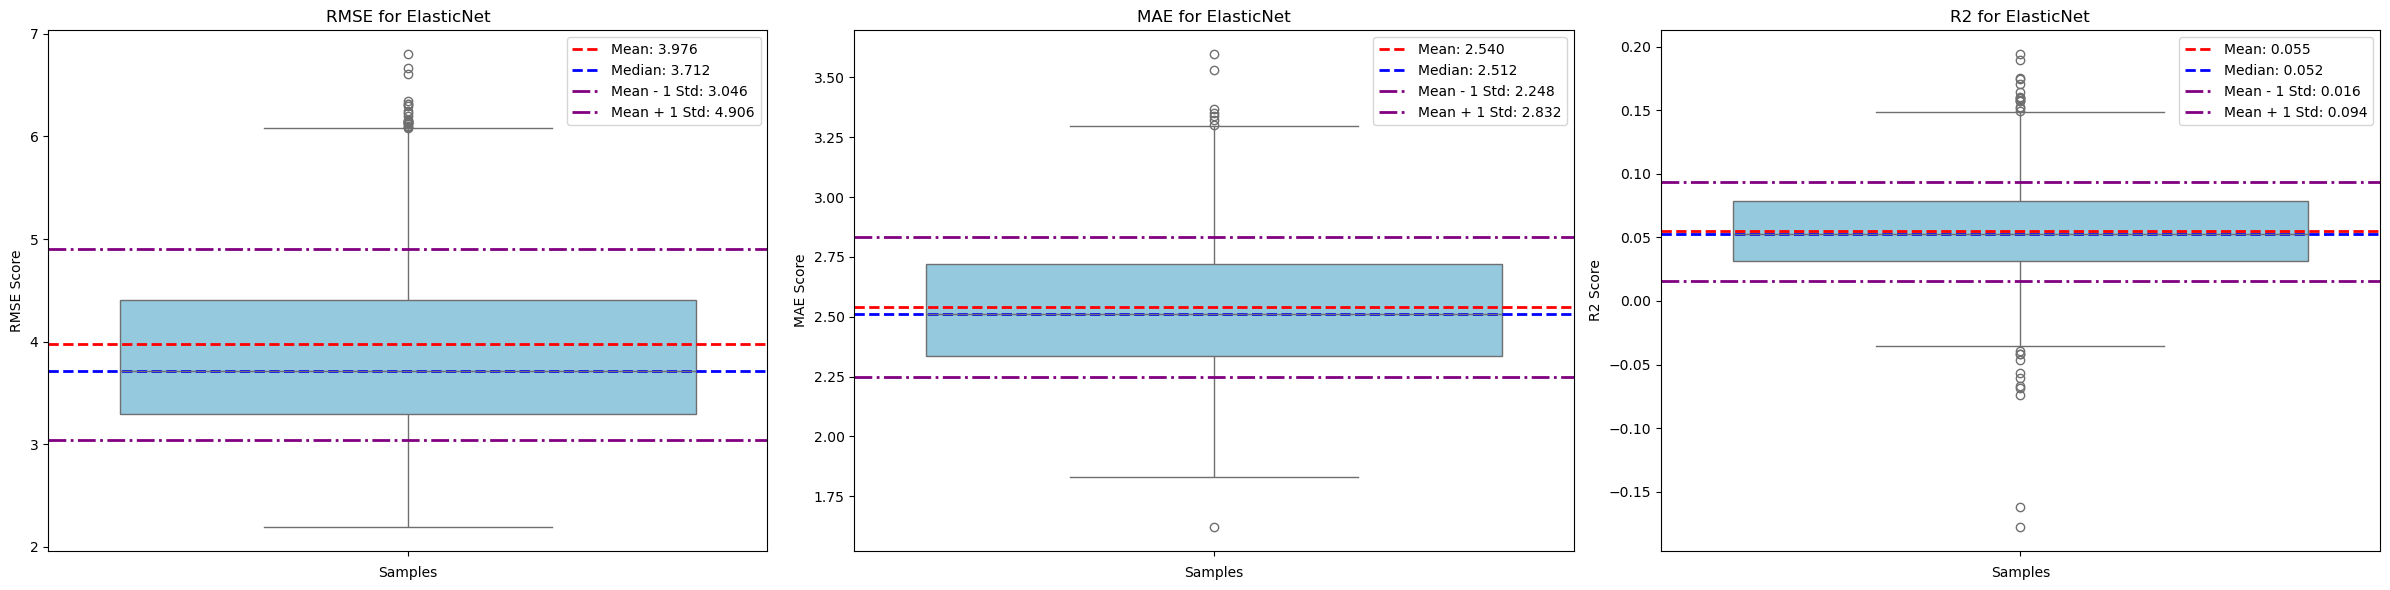

Model: BayesianRidge


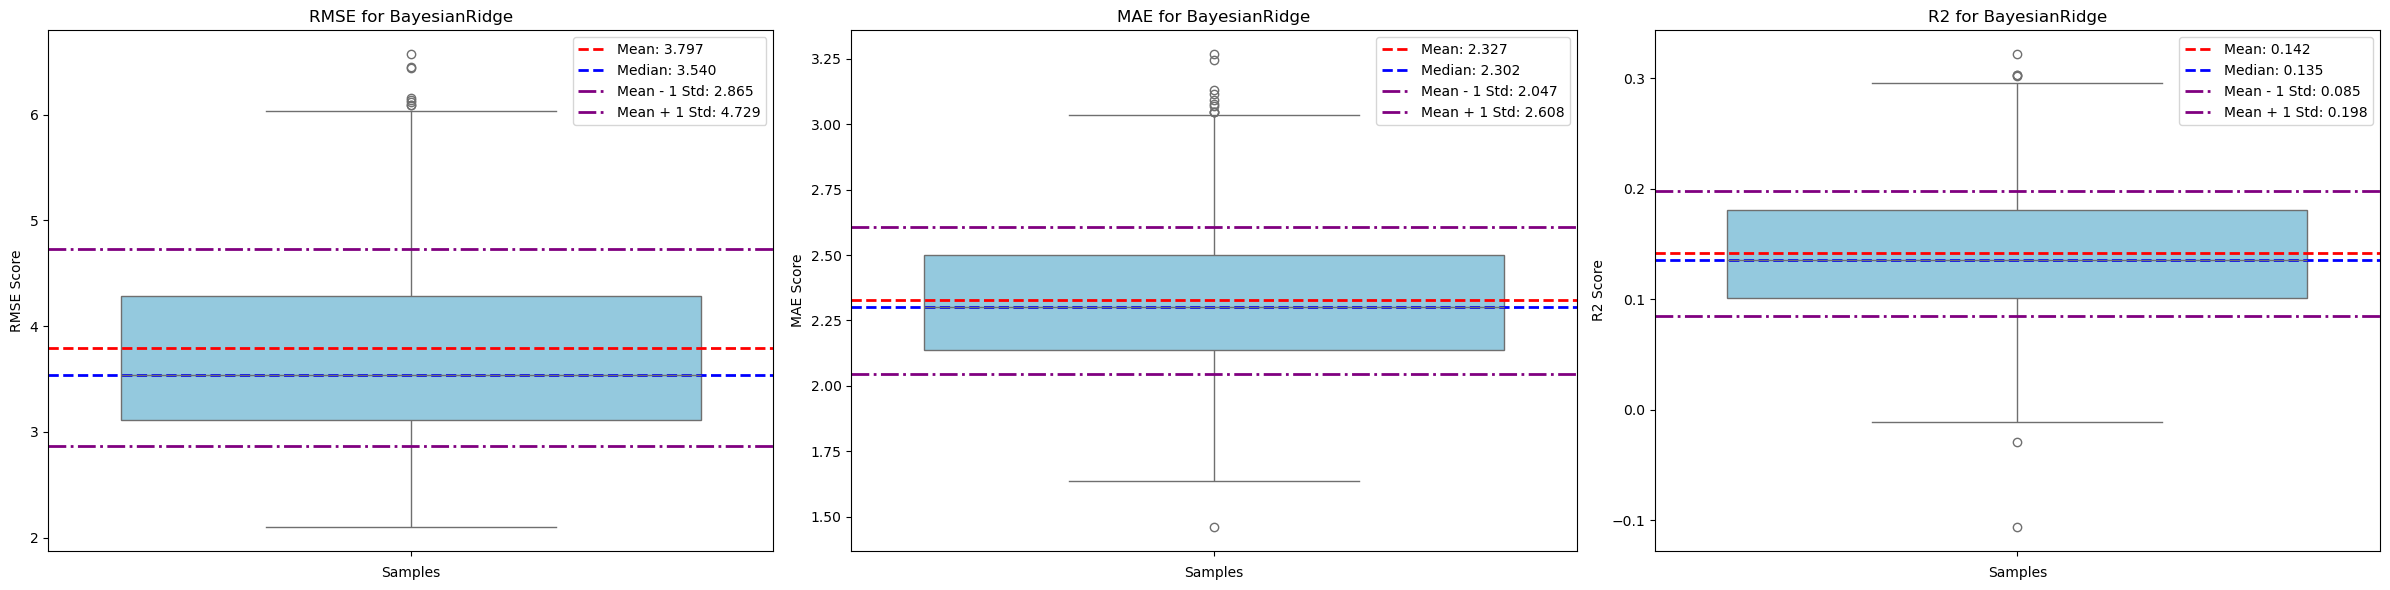

Model: SVR


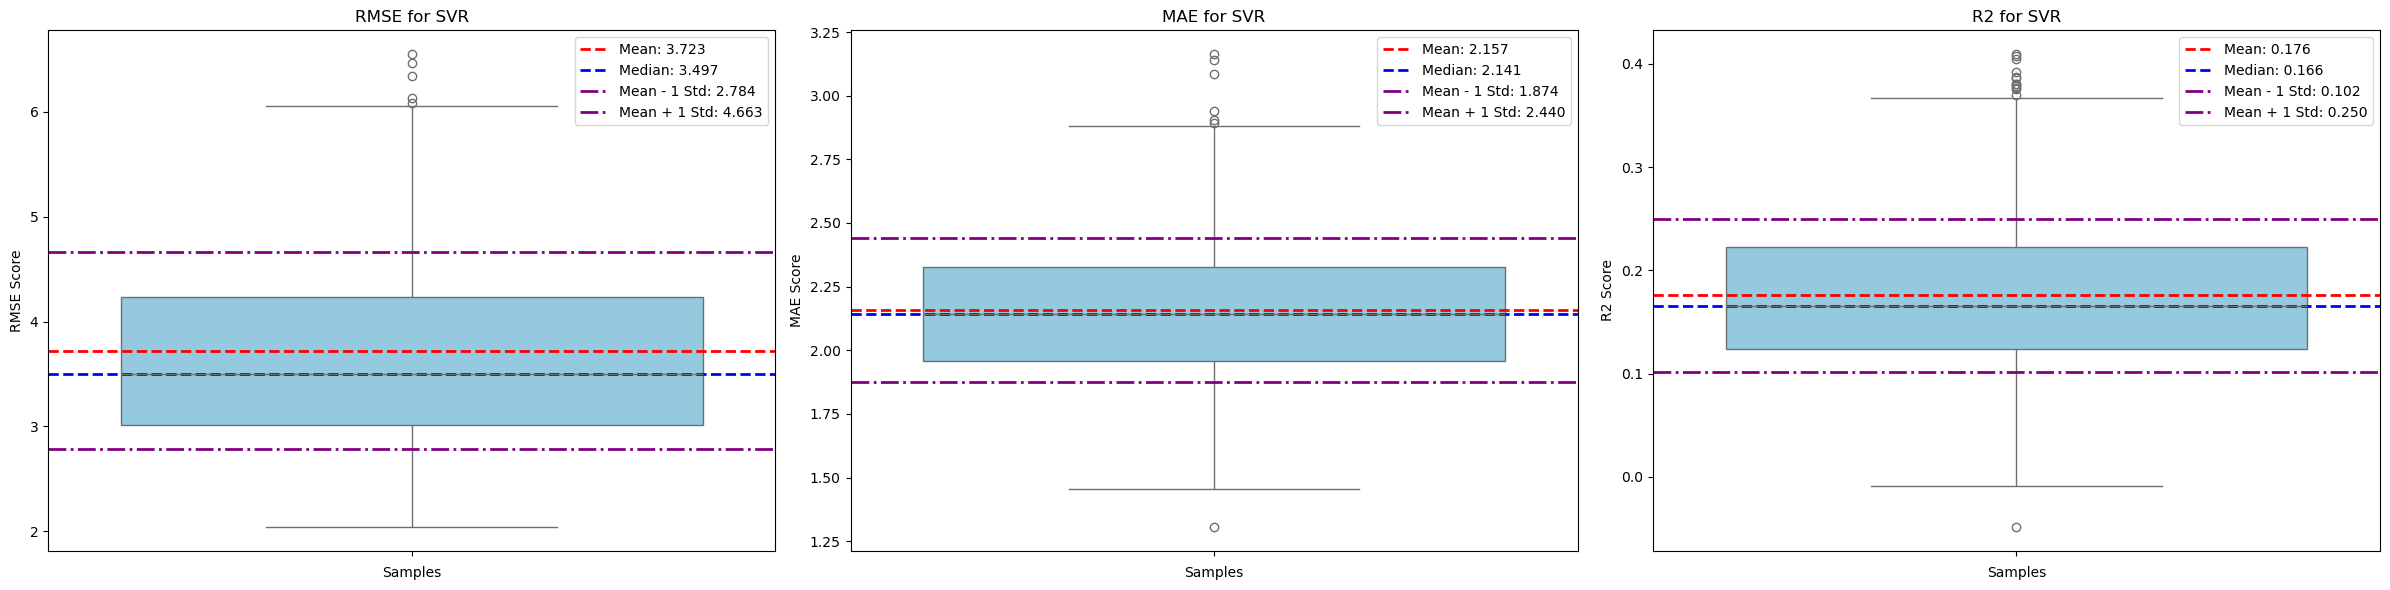

In [19]:
# Kfold Cross-Validation
models = [ElasticNet(alpha=0.3974487856623652, l1_ratio=0.37694544339595215), BayesianRidge(alpha_1=9.898457542238998e-05, alpha_2=3.5765987581243055e-05, lambda_1=3.034875809905059e-08, lambda_2=9.931322990446061e-05), SVR(C=3.407623577816608, gamma='auto', epsilon=0.0109936823779154, kernel='rbf')]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ in features_per_model.keys():
        x_mod = x[features_per_model[model.__class__.__name__]]
        val_x_mod = val_x[features_per_model[model.__class__.__name__]]
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=None)
        functions.bootstrap2boxplot(x_mod, y, val_x_mod, val_y, pipeline, n_iter=200, bstrap=False, kf=True, root_path=root, filename=f'{model.__class__.__name__}_optuna_sfs.pkl', save=True, default_path=True)

Model: ElasticNet


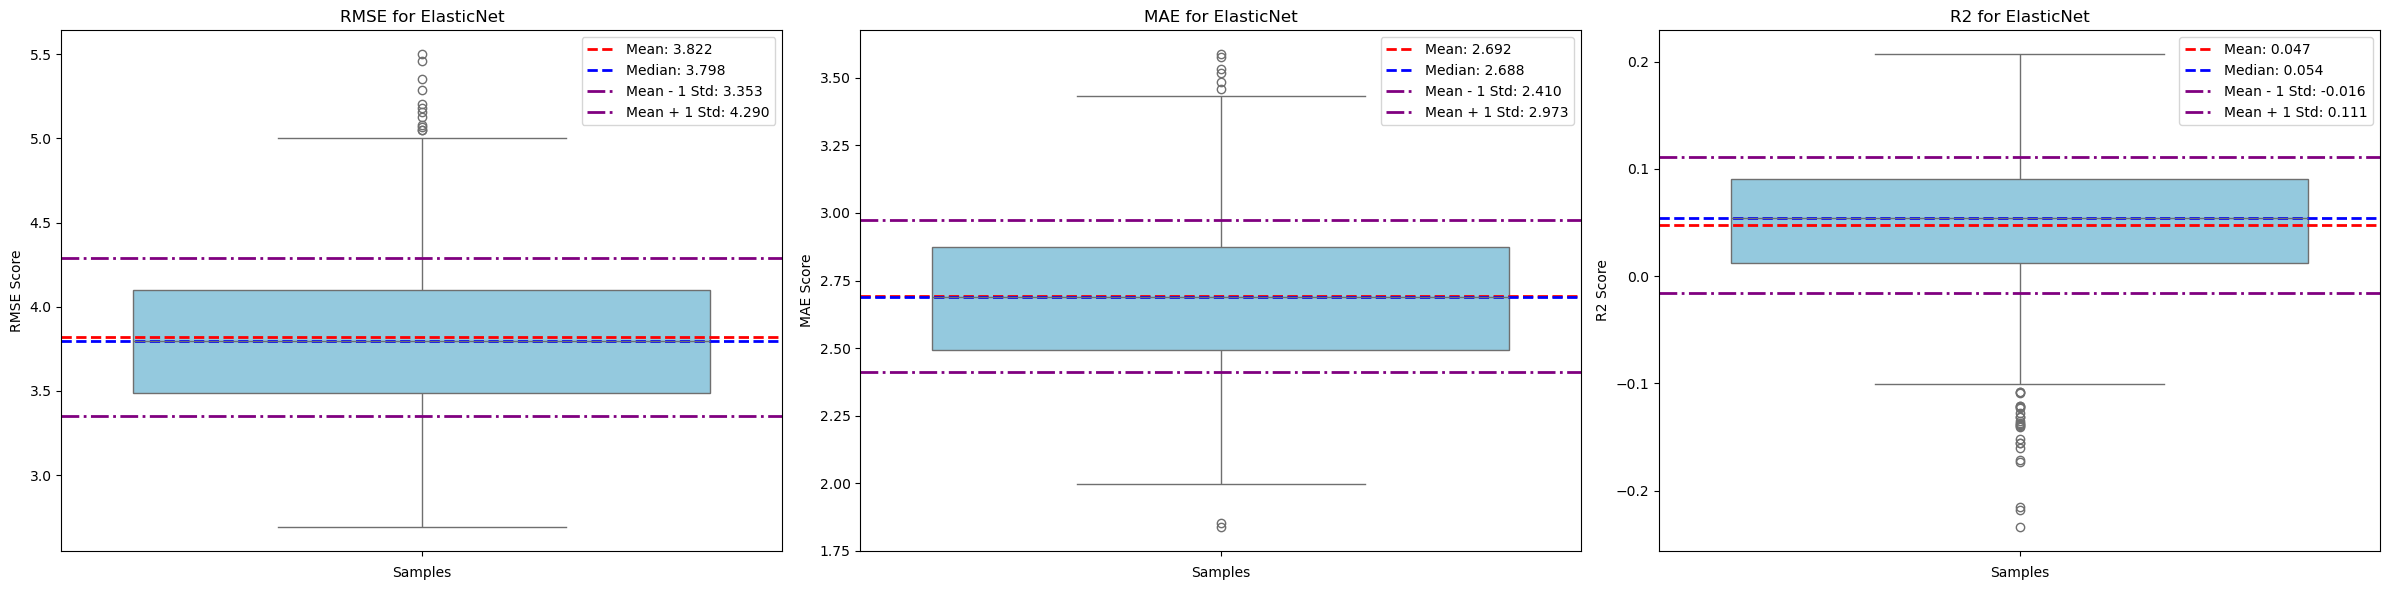

Model: BayesianRidge


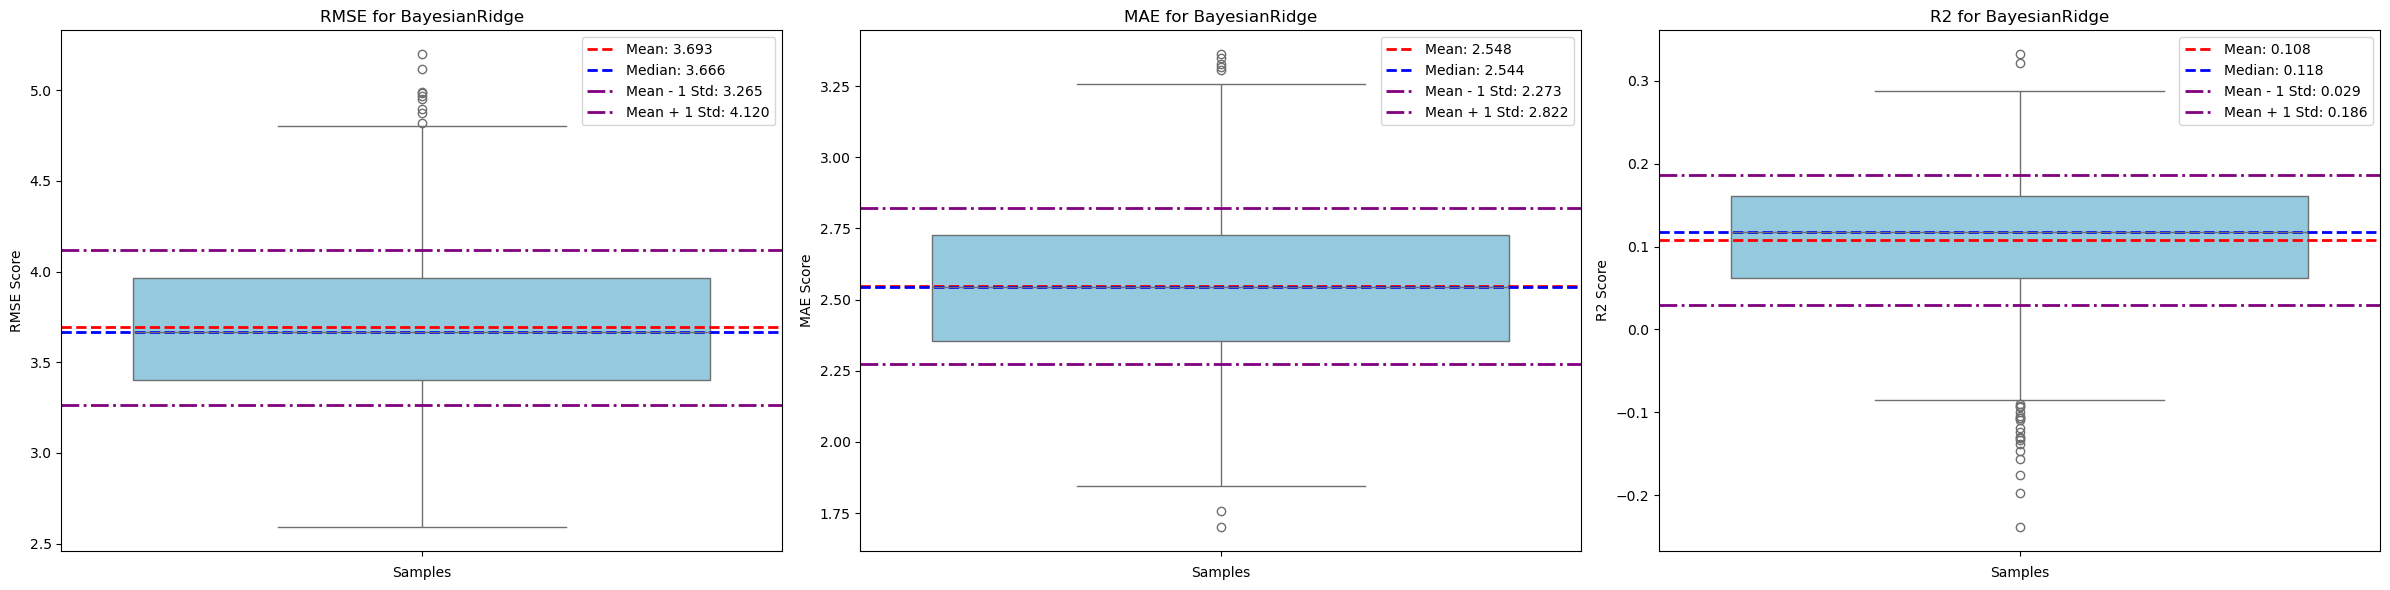

Model: SVR


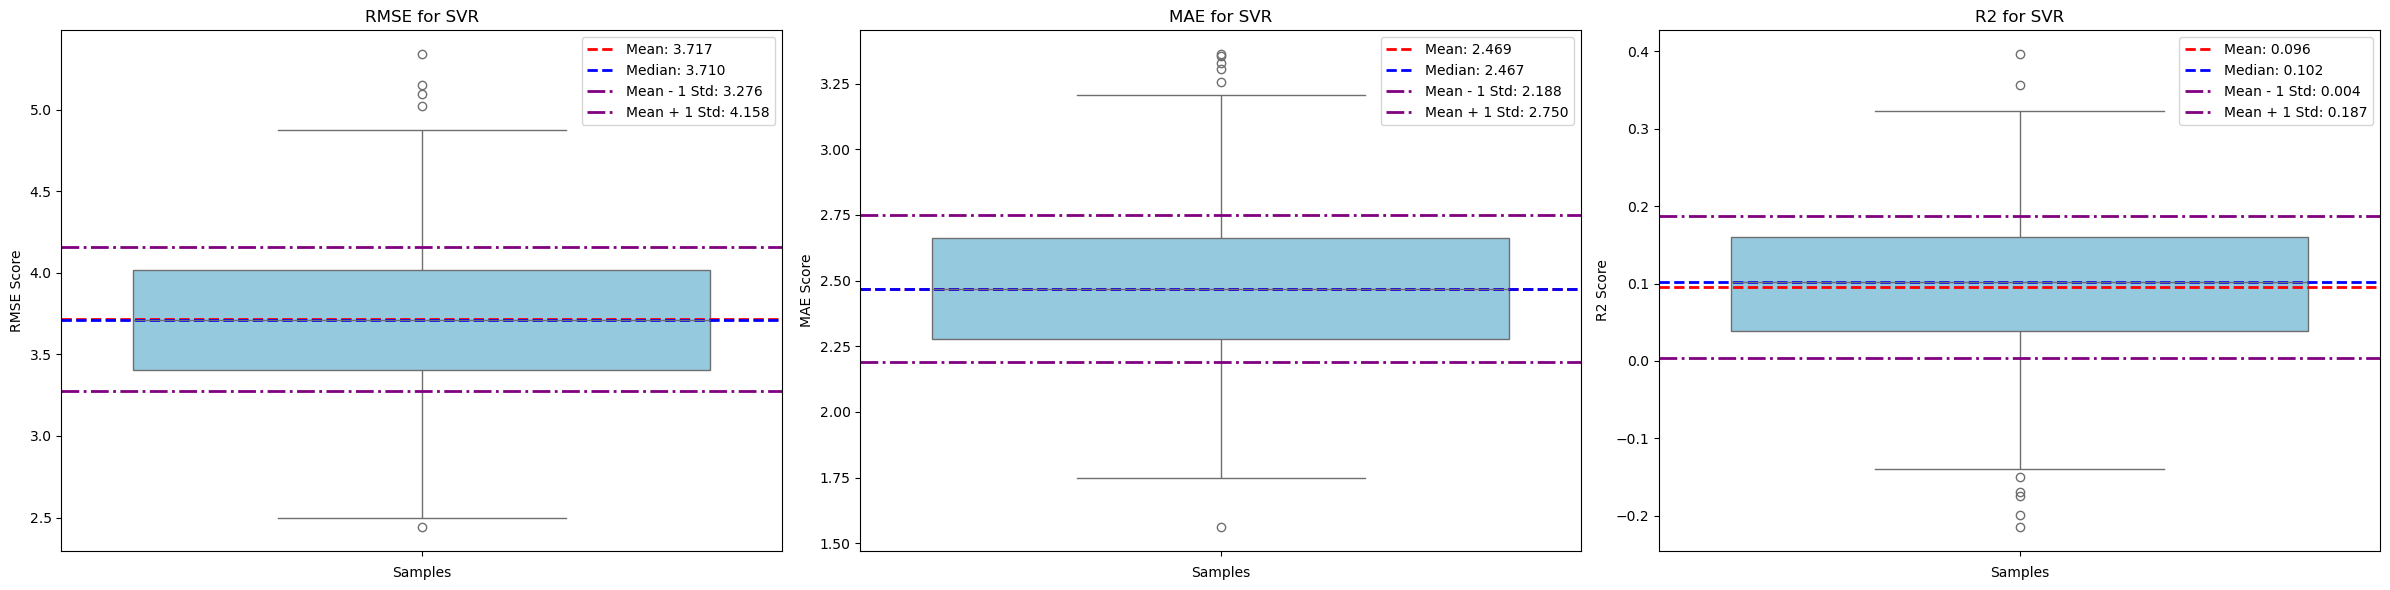

In [20]:
# Bootstrap Evaluation
models = [ElasticNet(alpha=0.3974487856623652, l1_ratio=0.37694544339595215), BayesianRidge(alpha_1=9.898457542238998e-05, alpha_2=3.5765987581243055e-05, lambda_1=3.034875809905059e-08, lambda_2=9.931322990446061e-05), SVR(C=3.407623577816608, gamma='auto', epsilon=0.0109936823779154, kernel='rbf')]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ in features_per_model.keys():
        x_mod = x[features_per_model[model.__class__.__name__]]
        val_x_mod = val_x[features_per_model[model.__class__.__name__]]
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=None)
        functions.bootstrap2boxplot(x_mod, y, val_x_mod, val_y, pipeline, n_iter=1000, bstrap=True, kf=False, save=False)

<hr>

## Winner model training and loading section

<p>The best model of every one tested, was deemed to be the SVR with PCA as the feature selection method. The analytical reasons behind this decision can be found in the report</p>

<p>Here the function from from functions.py is called to train, store and load the winner model on both the development and the evaluation set as mentioned in the instructions.</p>


In [ ]:
initial_df = pd.read_csv(root / "data" / "assignment1_dev_set.csv", header=0)
initial_val_df = pd.read_csv(root / "data" / "assignment1_val_set.csv", header=0)
all_df = pd.concat([initial_df, initial_val_df])
winner_path = str(root)+"/models/final_models/"
final_df = all_df.drop(columns=['Unnamed: 0', 'Experiment type', 'Disease MESH ID', 'Sex', 'Project ID', 'Host age'])
x = final_df.drop(columns=['BMI'])
y = final_df['BMI']
final_pipeline = functions.create_pipeline(SVR(C=3.9290765618121544, gamma='scale', epsilon=0.06466478710466253, kernel='rbf'), scaler=True, feature_selector=PCA(n_components=94))
preds, trained_pipeline = functions.train_model_and_predict(x, y, x, final_pipeline, root_path=winner_path, filename="winner.pkl", save=True, default_path=False)


**You can load the winner model by pasting the absolute path to the function below.**

In [22]:
# Paste the absolute path of your csv file here
preds = functions.bmi_pred(df_path='/Volumes/Mac/Users/rafailadam/Downloads/mlincompbio/Assignment-1/data/assignment1_val_set.csv')
print(preds)

[25.61643271 25.22871918 22.41628342 25.44824358 25.22871918 25.38811631
 21.12200255 26.43928769 24.88702408 25.70369643 21.82645594 22.14400485
 25.84950452 20.73143598 25.36414864 24.19832335 24.01356574 24.78261941
 24.56387291 25.09315021 24.16524774 26.40884091 28.75723181 25.72606693
 25.72422973 25.22871918 25.32402307 25.53467898 20.06579989 25.93613322
 21.71080979 26.43050382 19.93119274 25.86854377 25.9570838  26.4553651
 25.86481991 26.10337985 23.83954588 25.56510172 26.37302075 29.91898081
 25.73408813 23.00480304 23.44684784 24.44503097 20.73344215 23.56445101
 25.22871918 20.05095235 30.20315371 21.82987138 25.1877685  27.30533274
 25.27242828 22.58000649 25.70206399 25.85844742 25.88050555 23.77942772
 26.54367375 25.23865112 20.59532207 21.28938679 23.11369436 21.37294673
 23.77332599 25.91450975 25.22871918 20.06335108 27.32101265 26.67251587
 25.22871918 24.71795018 21.36461885 25.31386373 25.22871918 22.46002188
 25.85092729 21.14994517 24.99402019 28.39518647 24.